In [1]:
import anndata as ad
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
%load_ext autoreload

%autoreload 2
from spatial_compare import  SpatialCompare, spatial_detection_scores

# Load Data
Here I have taken 4 small regions from different sections of Xenium data from the marmoset brain

In [2]:

ad1 = ad.read_h5ad("../data/CJ_BG_mini1.h5ad")
ad2 = ad.read_h5ad("../data/CJ_BG_mini2.h5ad")
ad3 = ad.read_h5ad("../data/CJ_BG_mini3.h5ad")
ad4 = ad.read_h5ad("../data/CJ_BG_mini4.h5ad")


### Start by creating the `SpatialCompare` object
### the anndata objects used in `spatial_compare` need a few things:

1. a category (column in .obs shared in both AnnData objects )
2. an `.obsm` key where spatial location data is stored
3. names for the datasets

This has some validation of shared genes and checks for the  shared `category` column in the `.obs`



In [3]:
sc = SpatialCompare(ad1, ad2, data_names=["mini1", "mini2"], category='AIT15_Subclass_name')

input anndata objects have 541 shared genes


### next we'll run spatial_compare
This generates (potentially many) plots:
1. a spatial plot of the 2 datasets, colored by the user-supplied category
2. population comparisons 
3. Gene expression plots for each group
4. Summary plots of transcript detection differences across cell types and genes

In [4]:
d1d2_cells = [g for g in ad1.obs.AIT15_Subclass_name.unique() if "D1" in g or "D2" in g]
non_d1d2_cells = [g for g in ad1.obs.AIT15_Subclass_name.unique() if g not in d1d2_cells]

at least 1 input has less than 10 cells in AIT15_Subclass_name == D2-Striosome
at least 1 input has less than 10 cells in AIT15_Subclass_name == D1-ShellOT
at least 1 input has less than 10 cells in AIT15_Subclass_name == D2-ShellOT
dict_keys(['D1-Matrix', 'D2-Matrix', 'D1-Striosome', 'D2-Hybrid-MCHR2', 'D1-NUDAP', 'D1D2-Hybrid'])


True

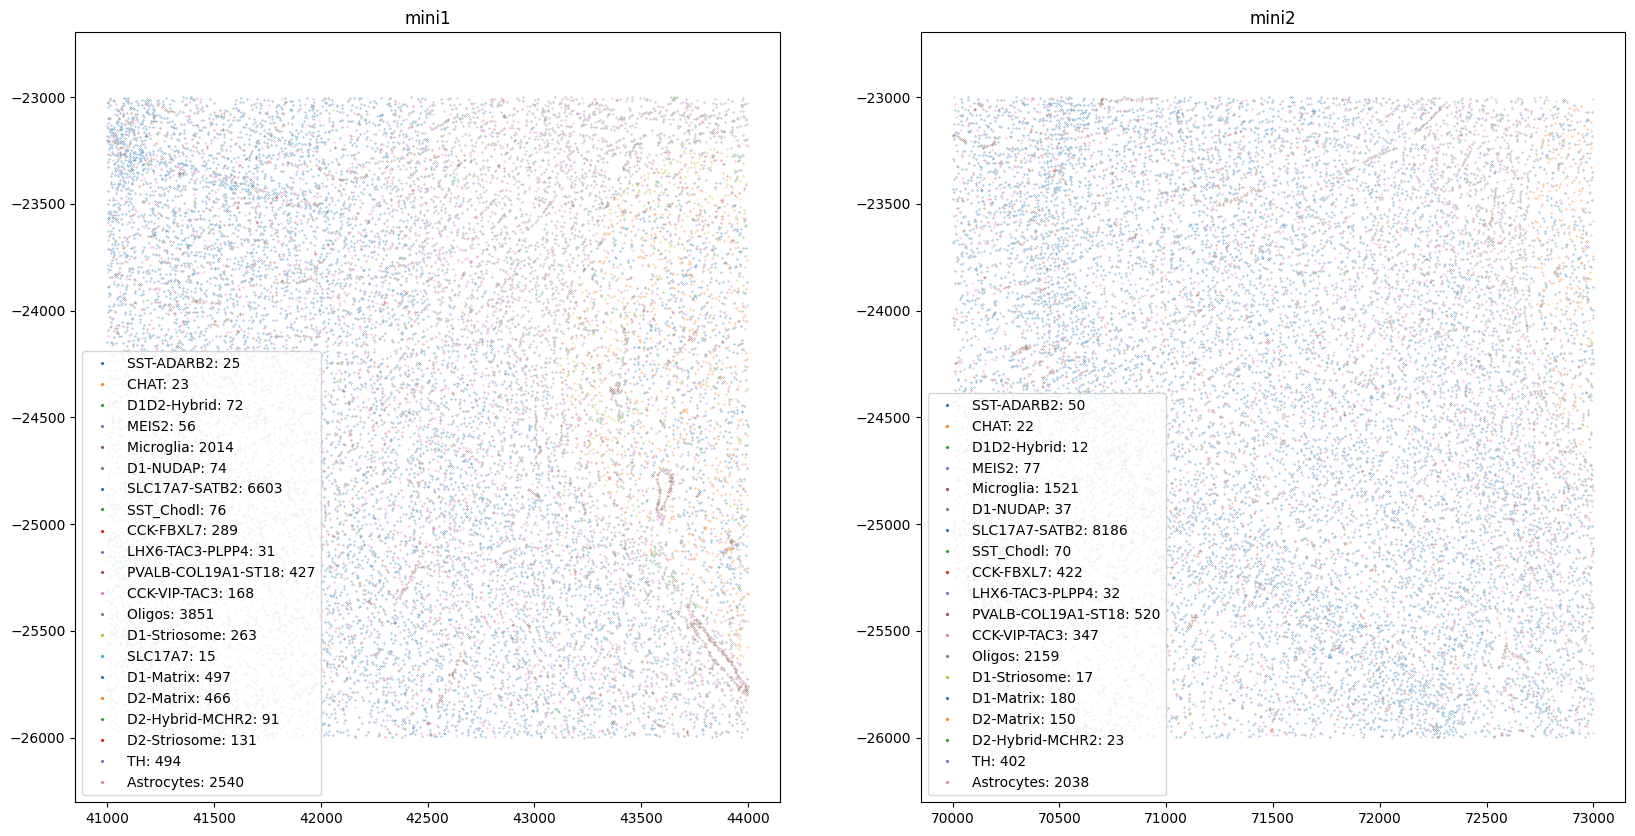

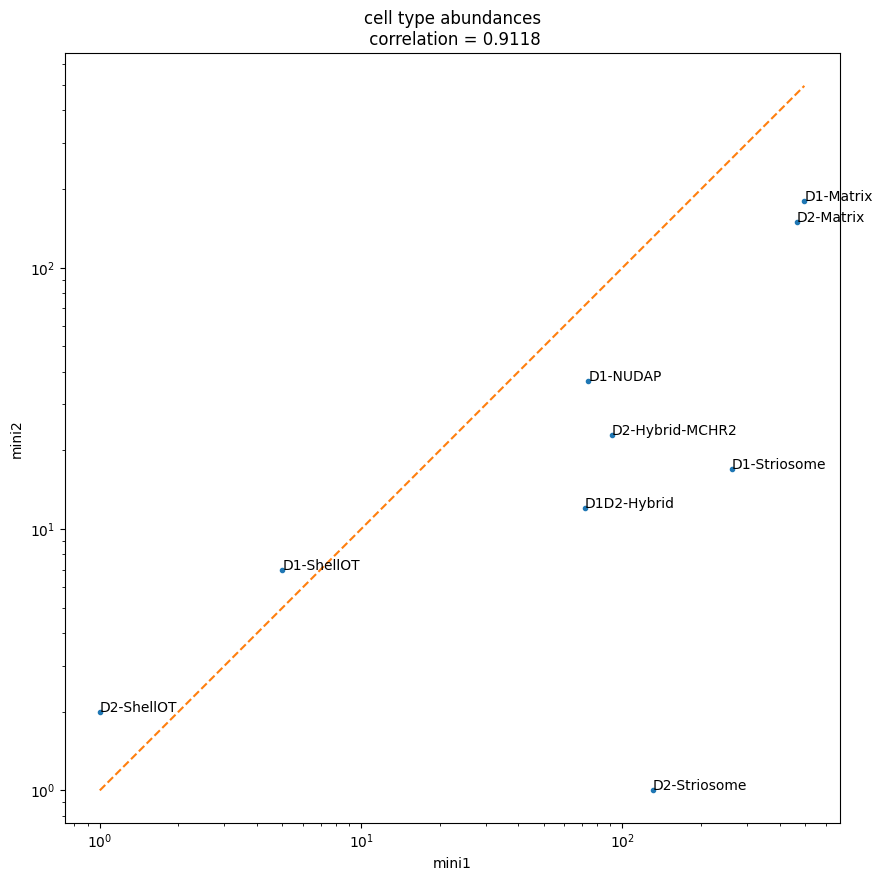

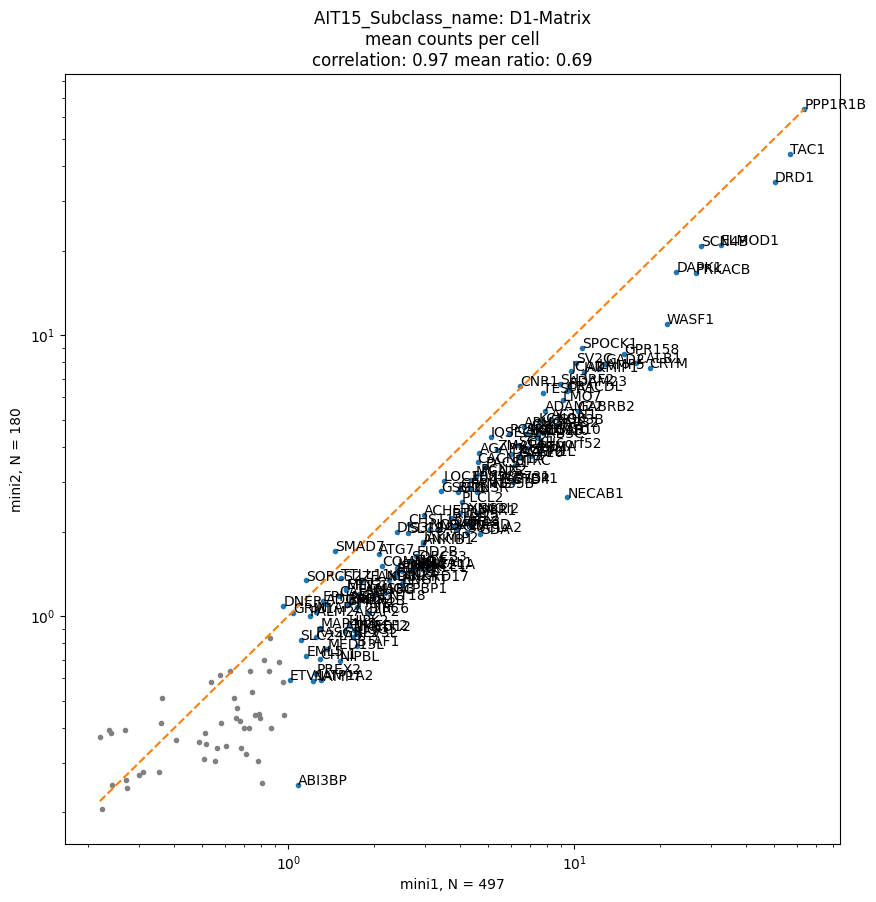

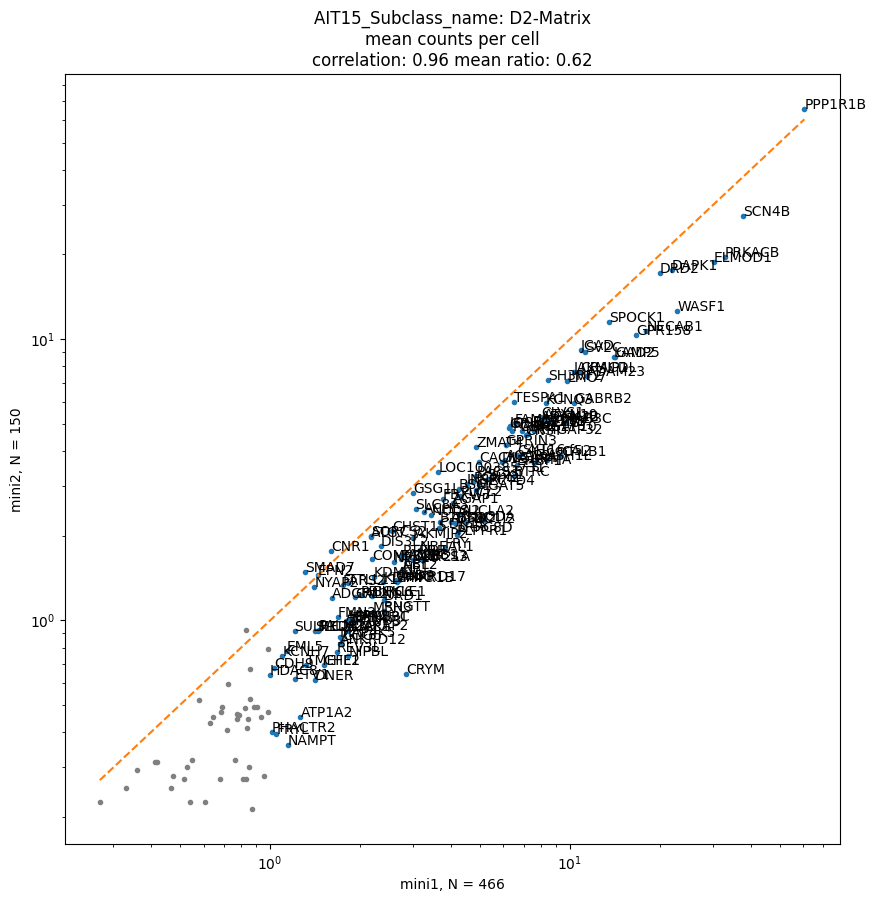

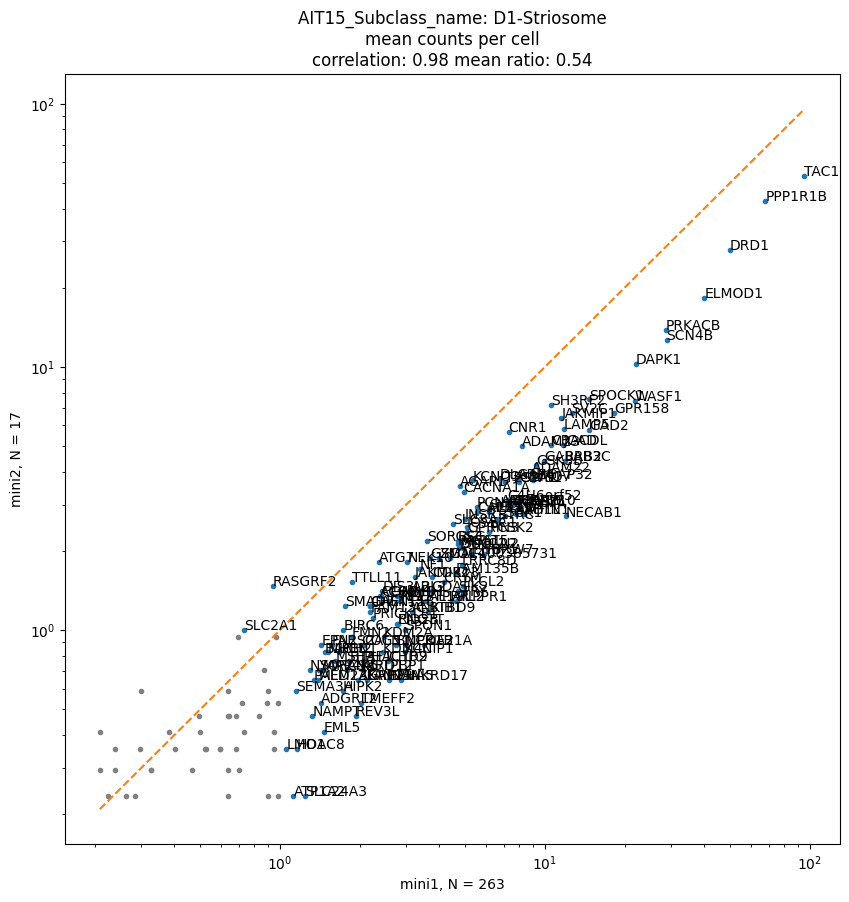

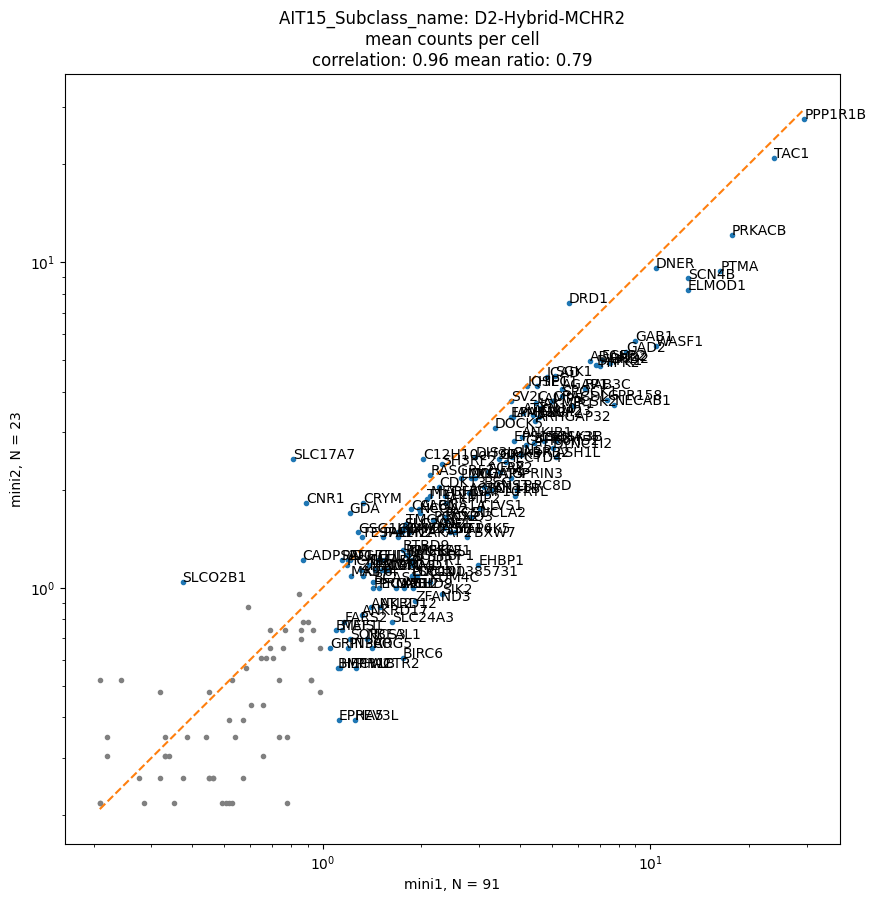

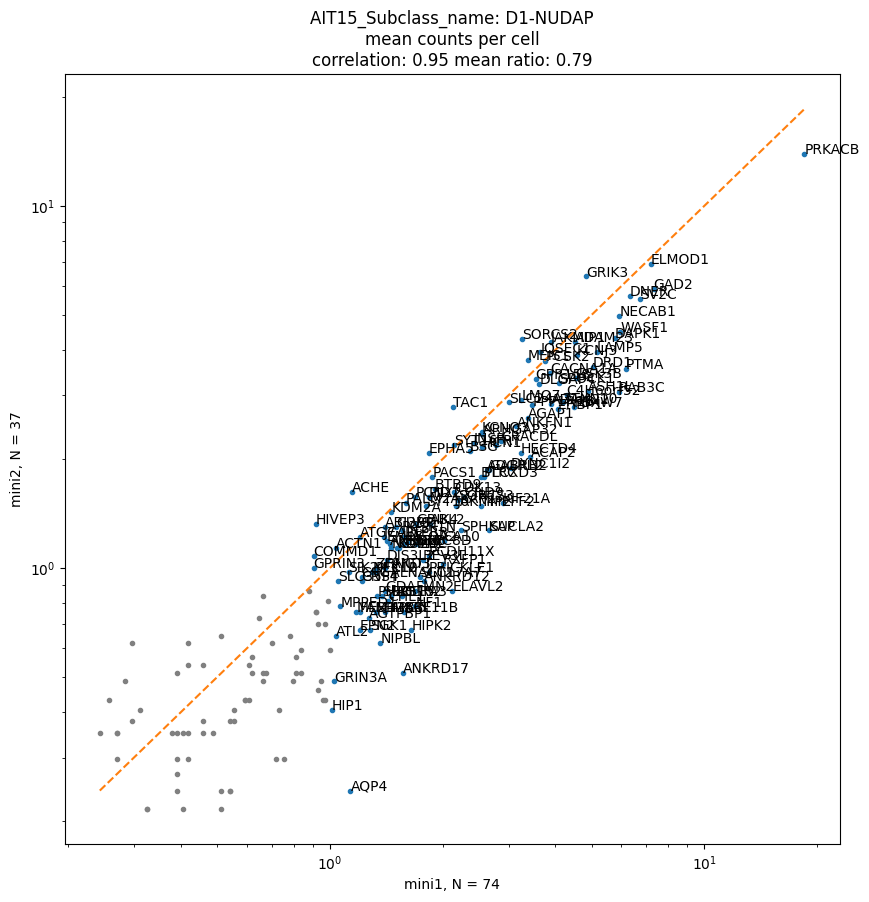

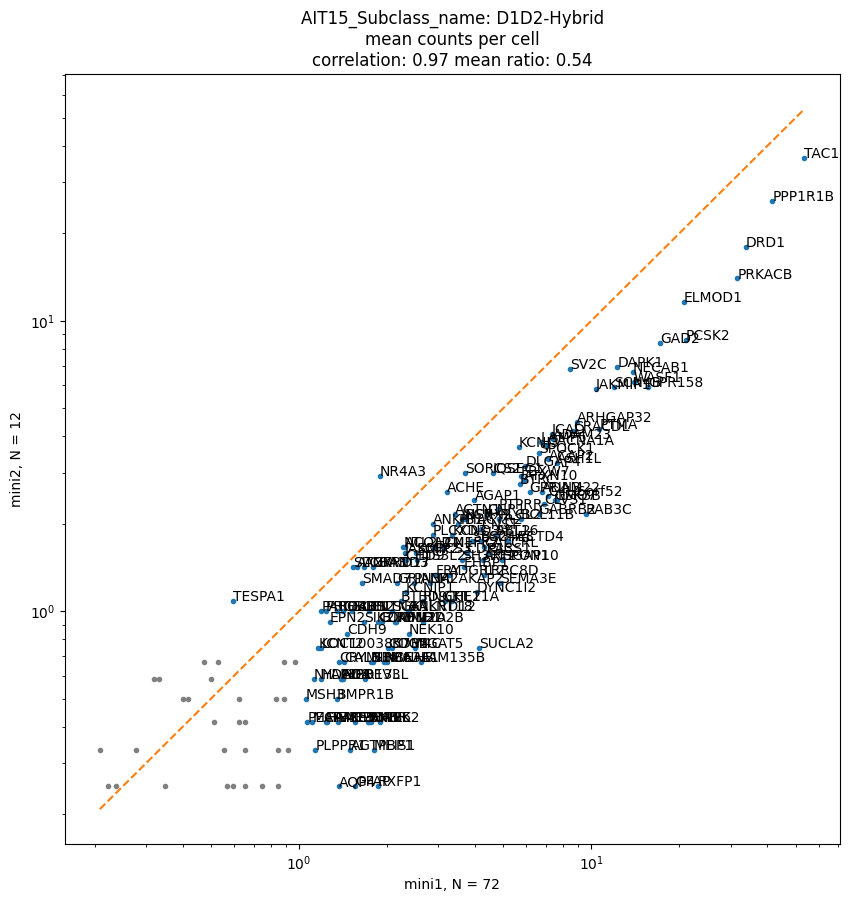

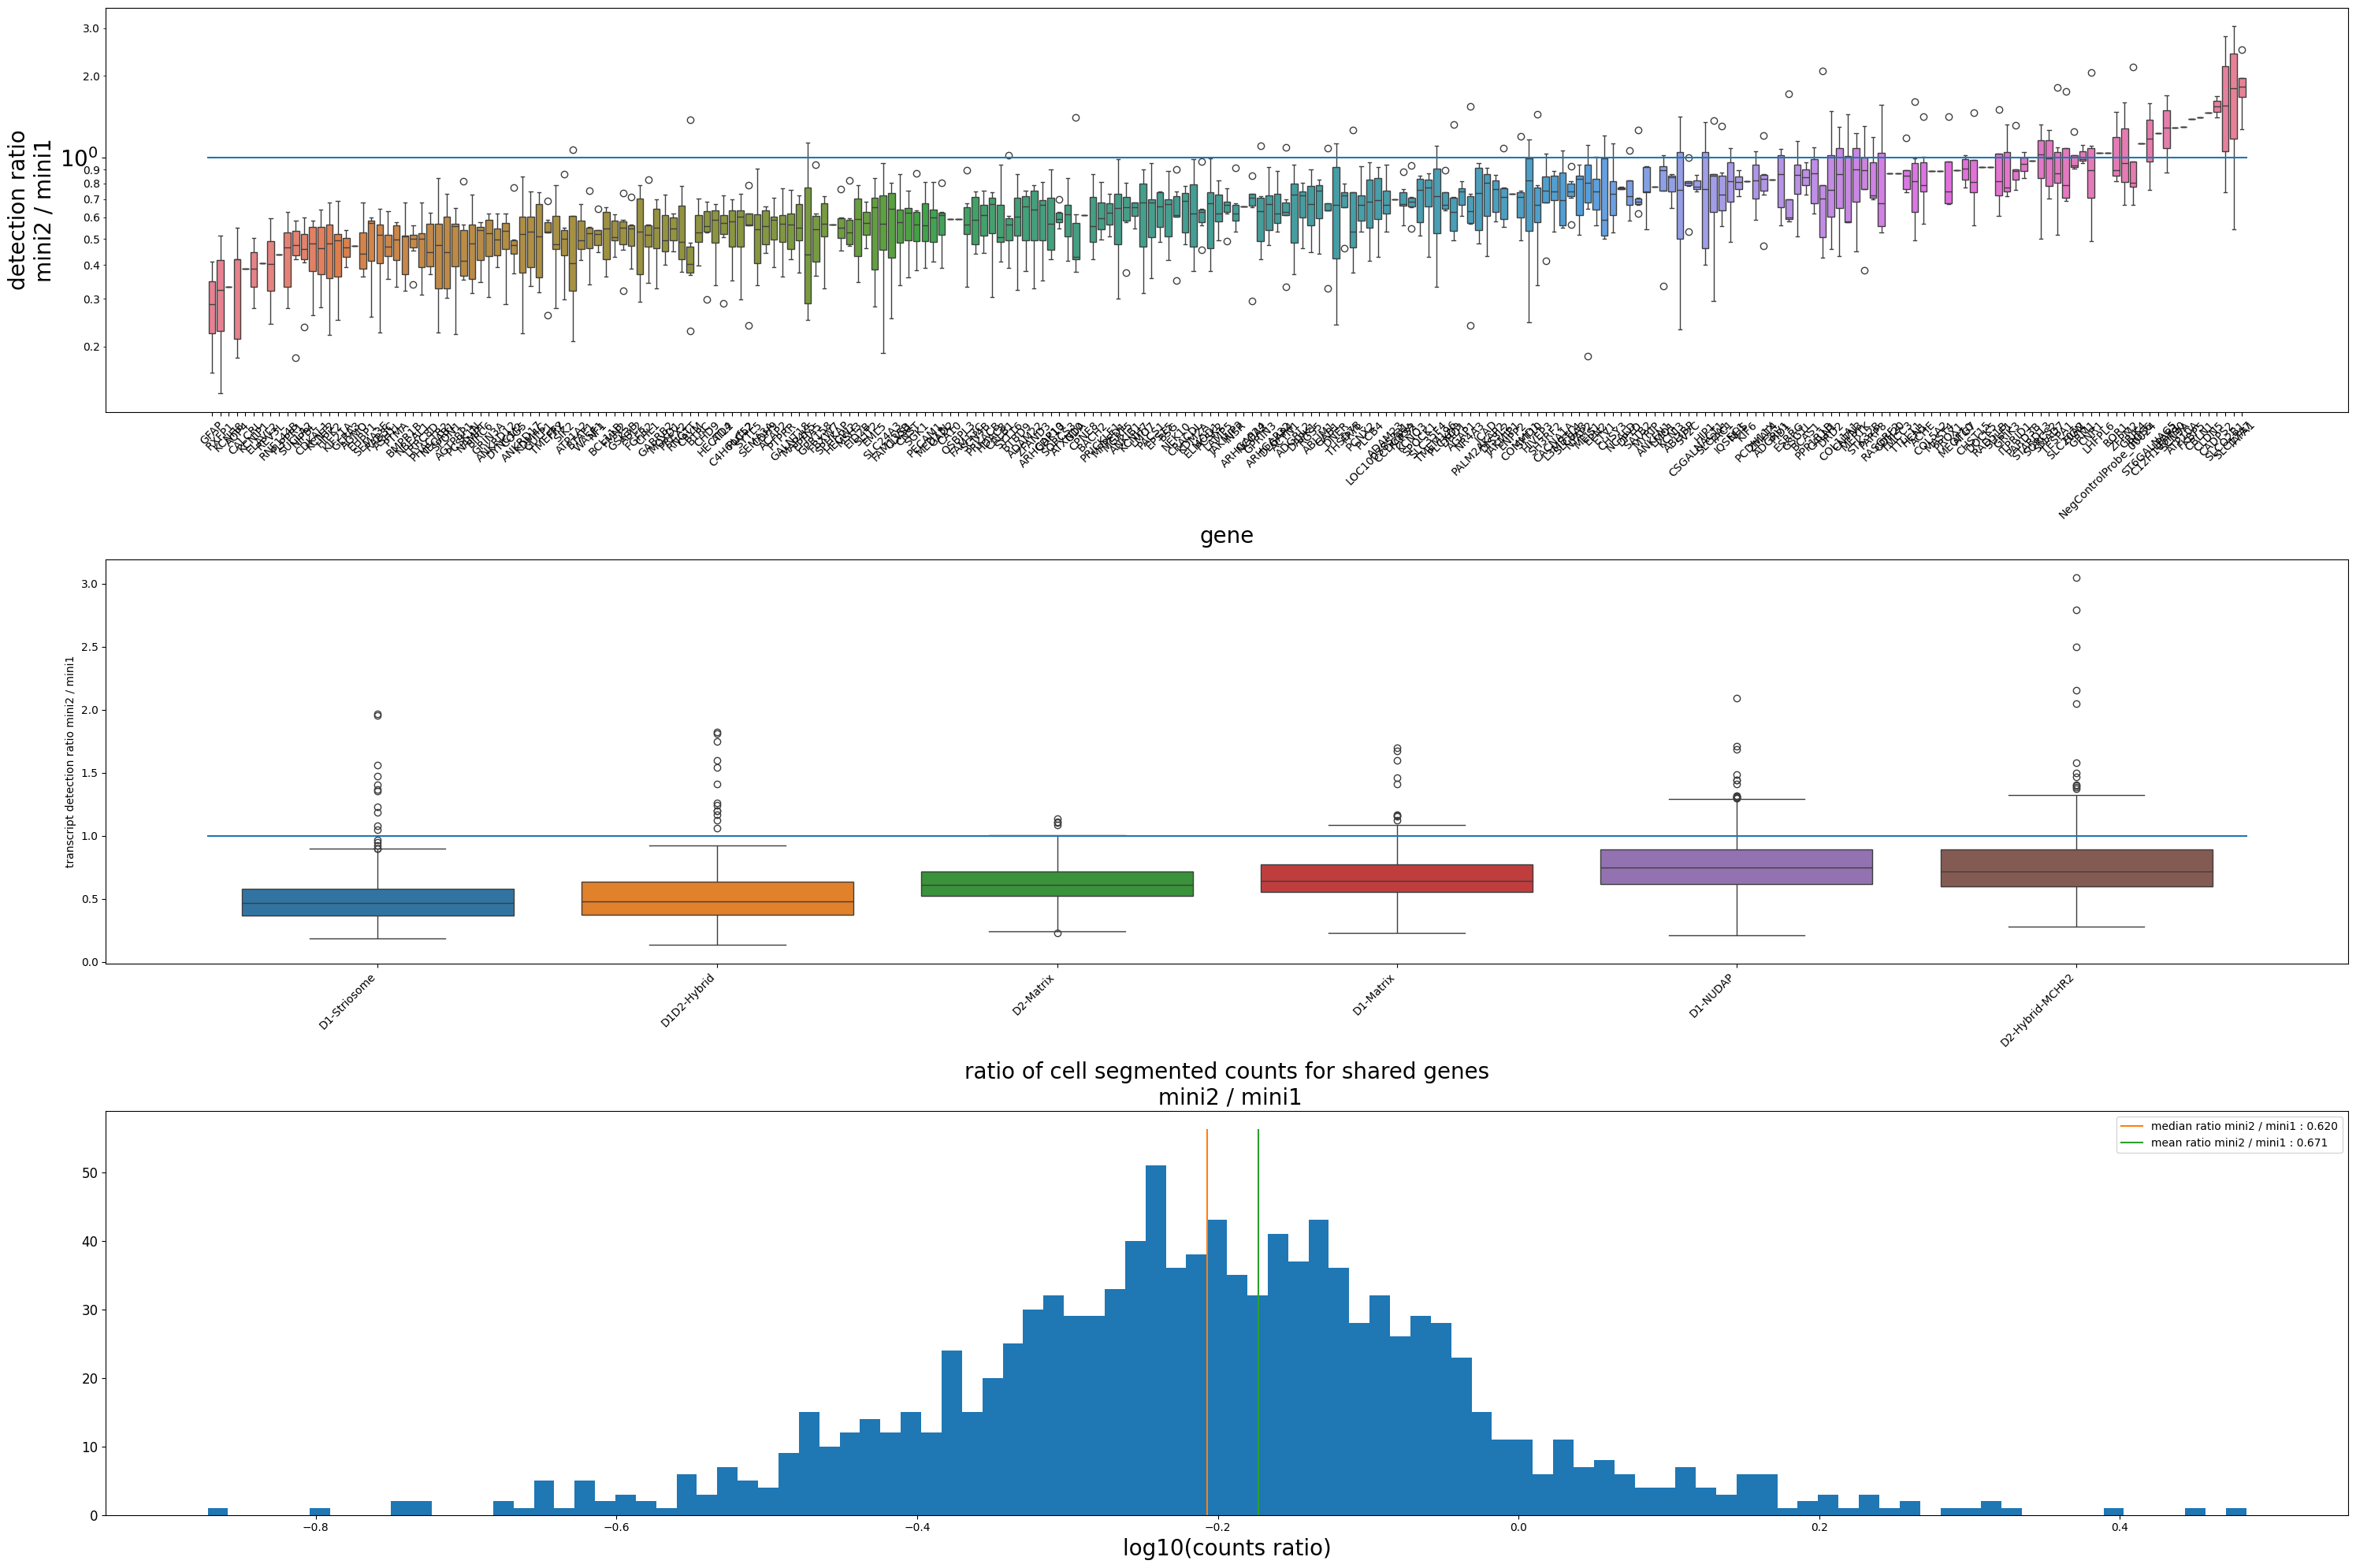

In [5]:
sc.run_and_plot(category_values = d1d2_cells, min_mean_expression=.2)



at least 1 input has less than 10 cells in AIT15_Subclass_name == SLC17A7
at least 1 input has less than 10 cells in AIT15_Subclass_name == TAC3-LHX8-PLPP4
at least 1 input has less than 10 cells in AIT15_Subclass_name == GABA_Gluta_PVALB-Meis2
at least 1 input has less than 10 cells in AIT15_Subclass_name == Gluta_PVALB-CDH23
at least 1 input has less than 10 cells in AIT15_Subclass_name == NAc-LHX8
at least 1 input has less than 10 cells in AIT15_Subclass_name == SN_STH_GPe-MEIS2-OTX2
dict_keys(['SLC17A7-SATB2', 'Oligos', 'Astrocytes', 'Microglia', 'TH', 'PVALB-COL19A1-ST18', 'CCK-FBXL7', 'CCK-VIP-TAC3', 'SST_Chodl', 'MEIS2', 'LHX6-TAC3-PLPP4', 'SST-ADARB2', 'CHAT'])


True

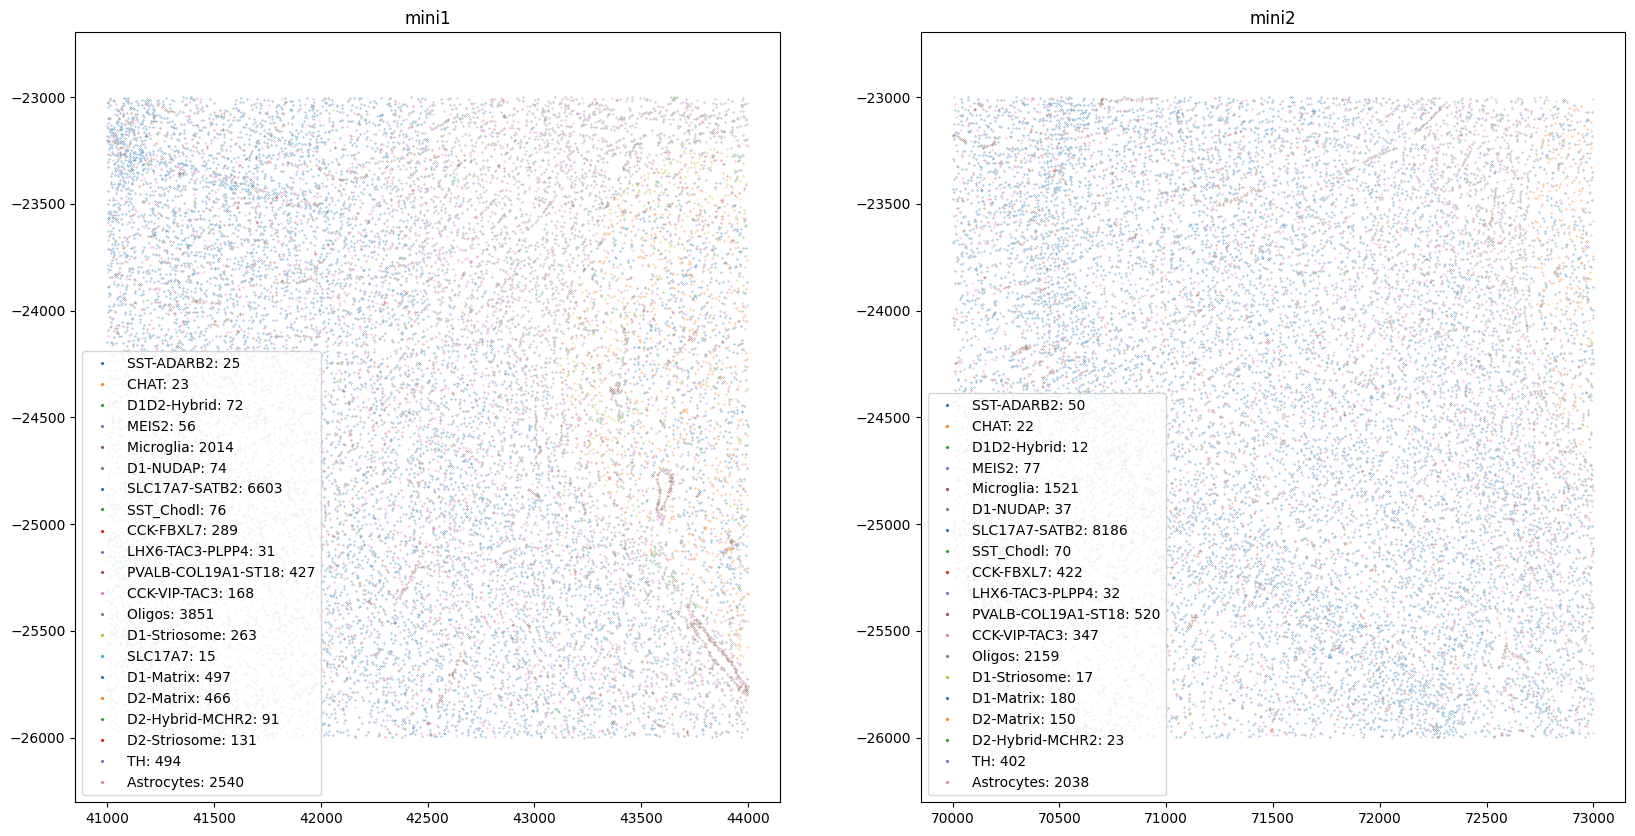

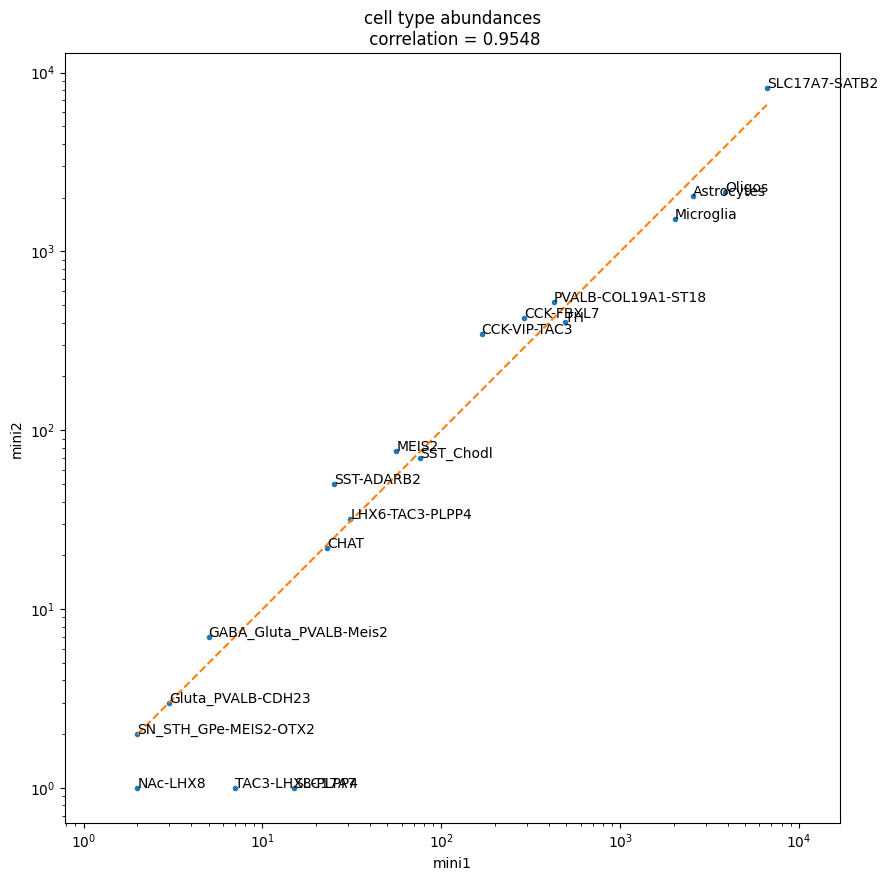

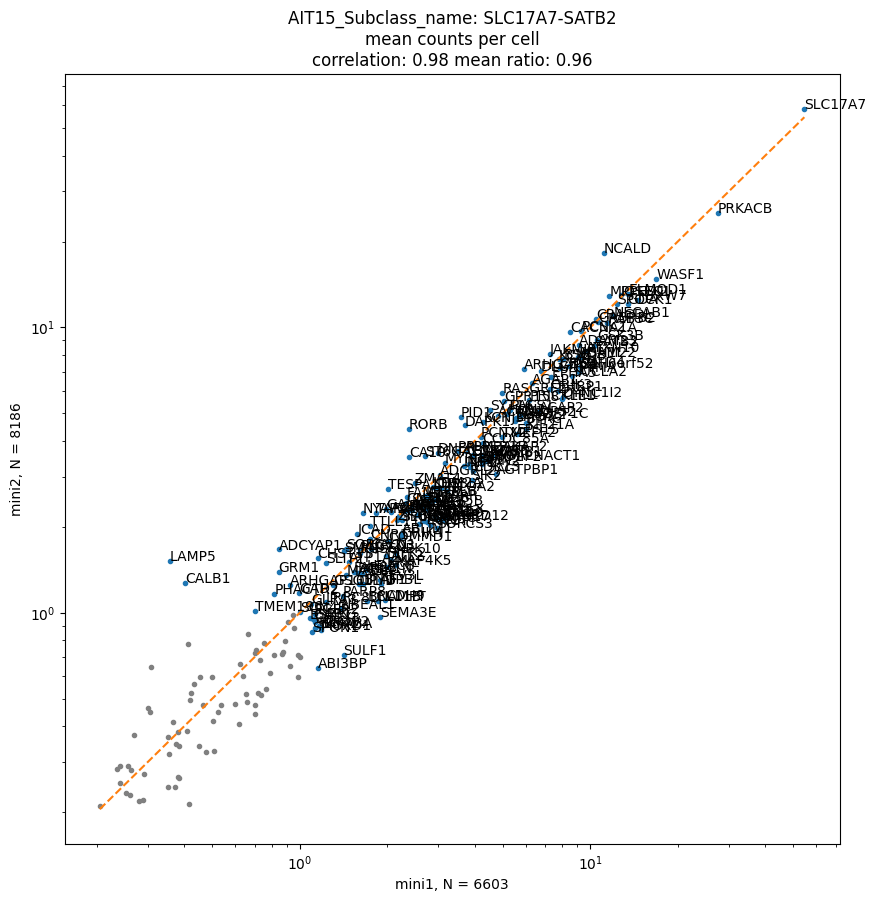

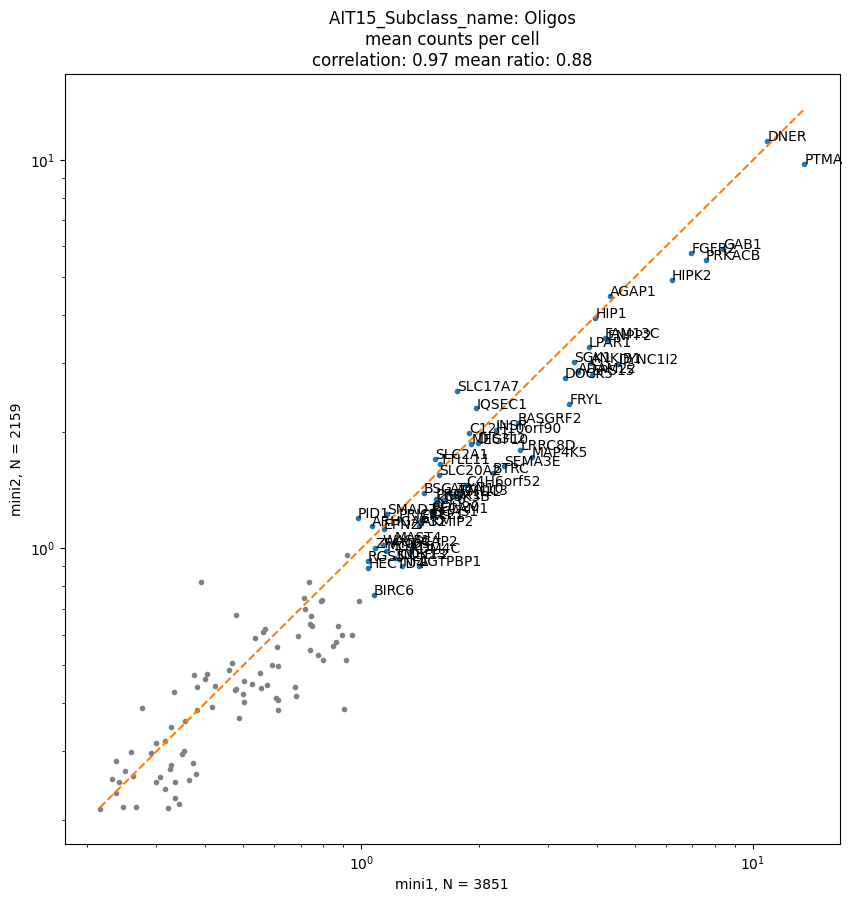

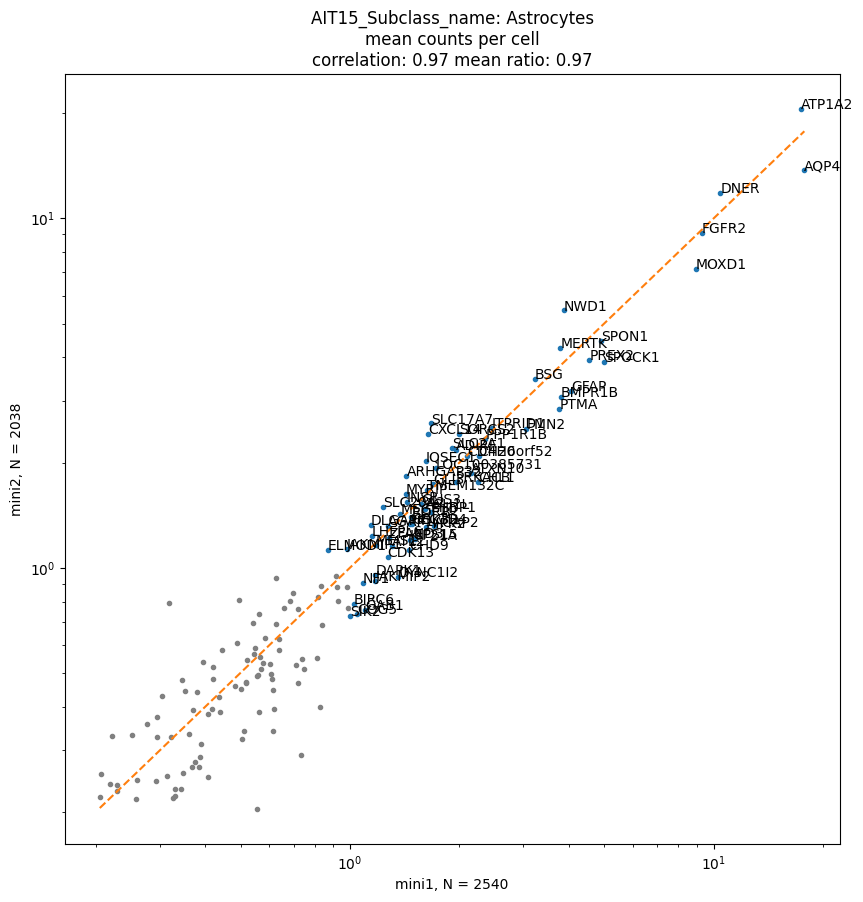

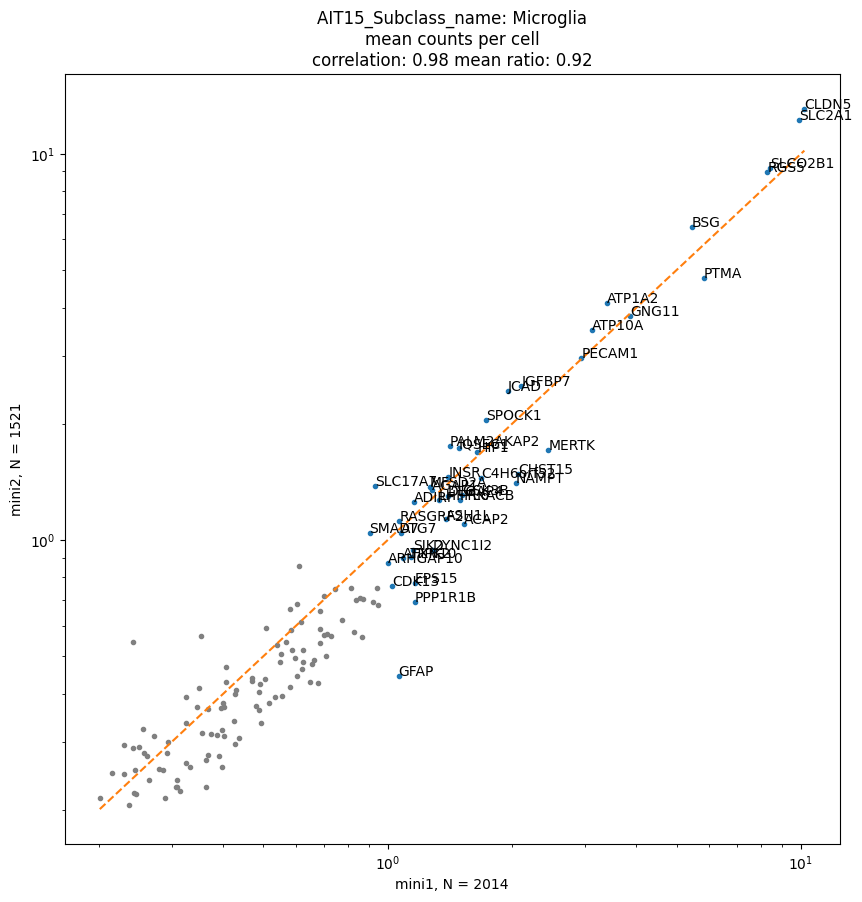

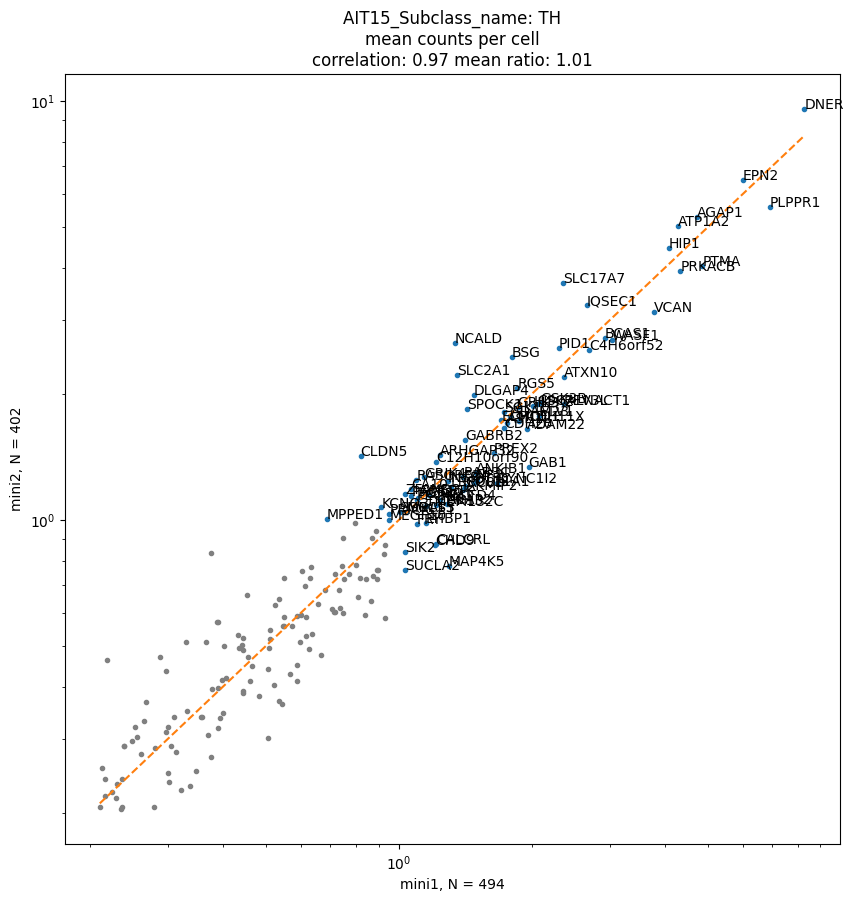

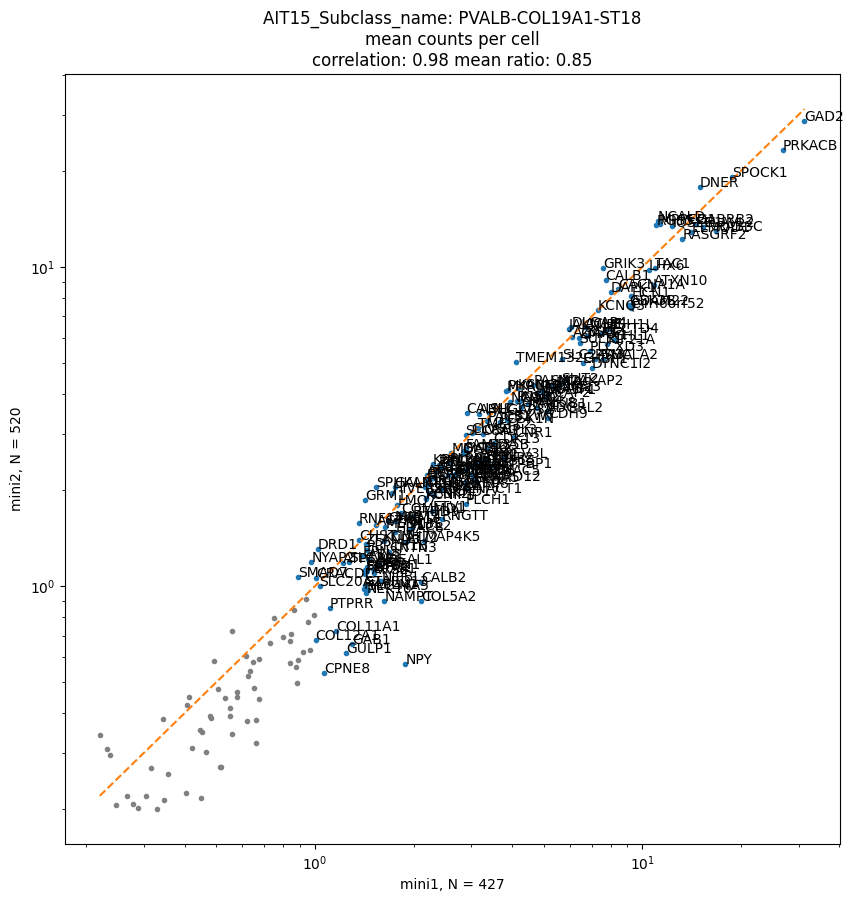

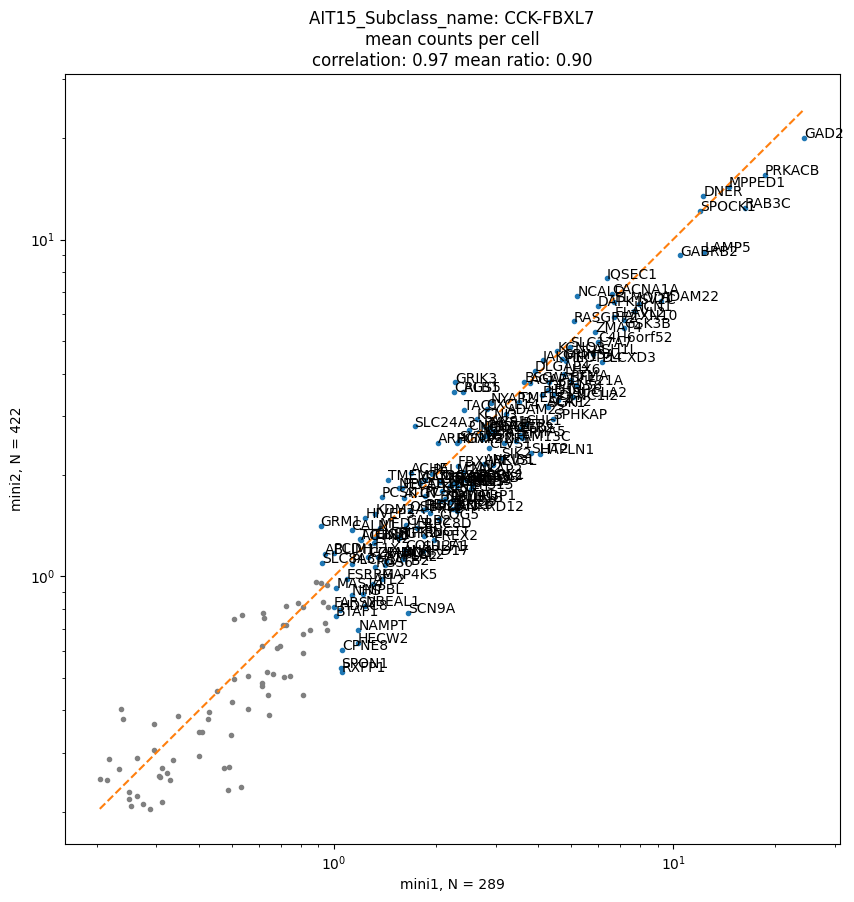

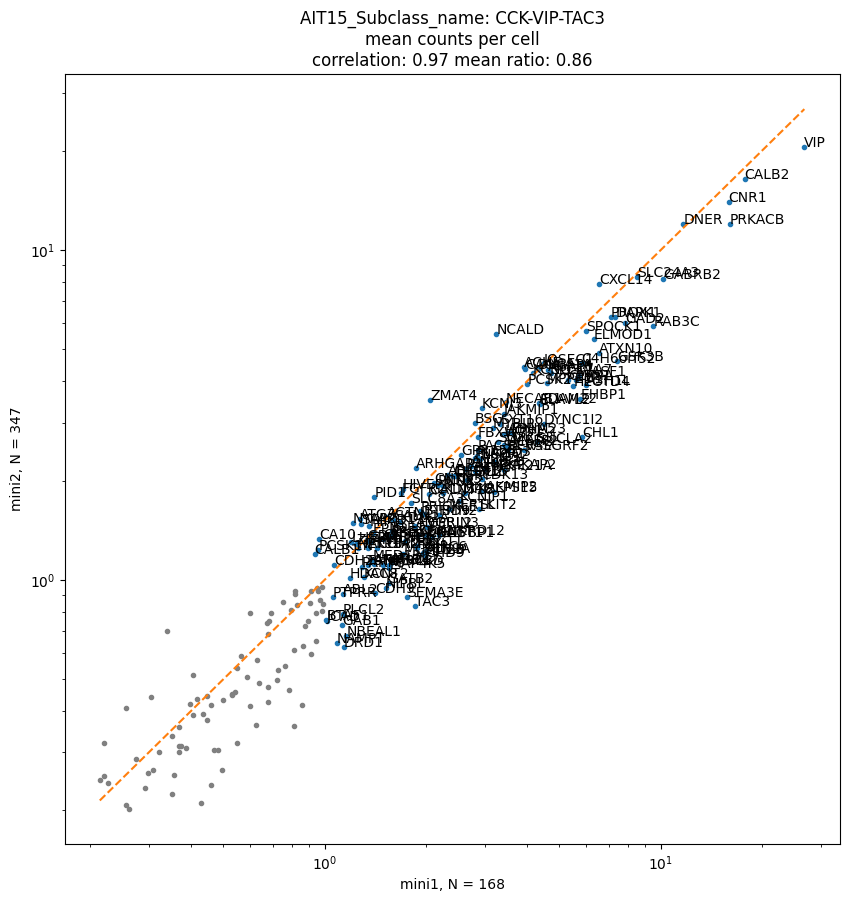

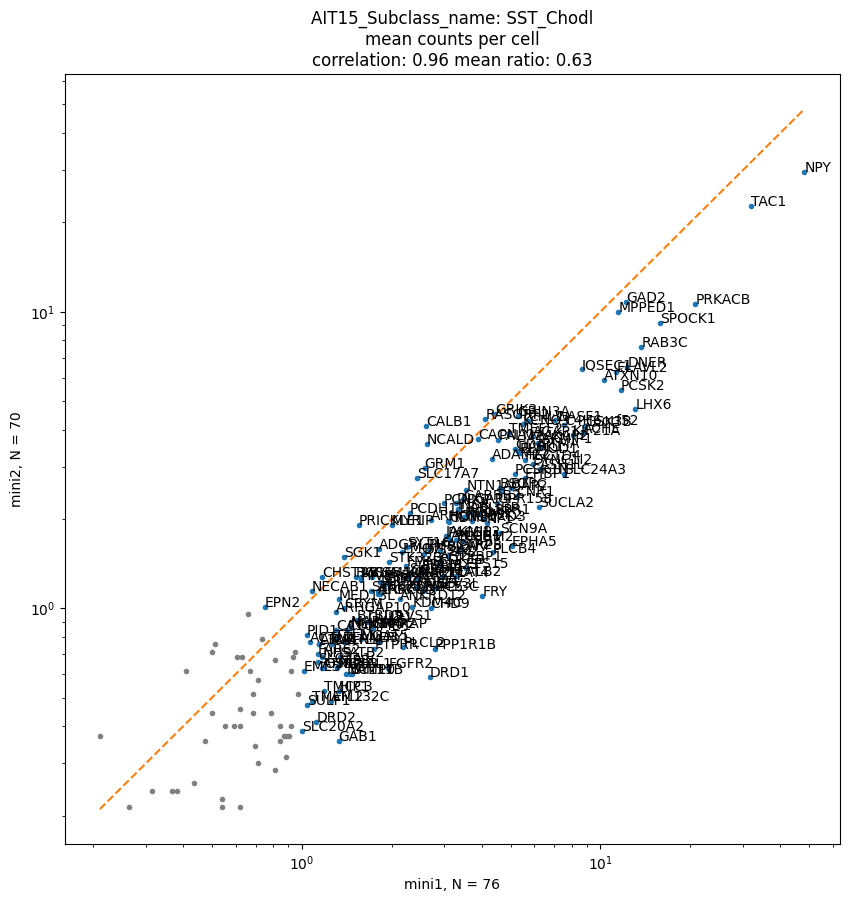

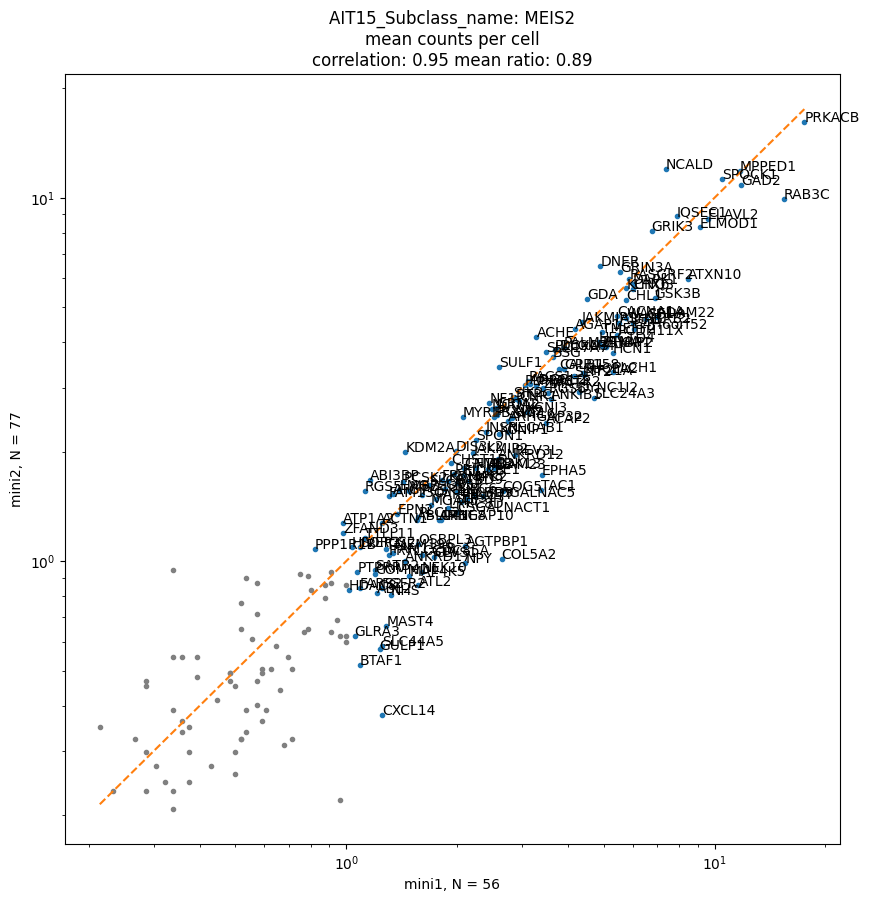

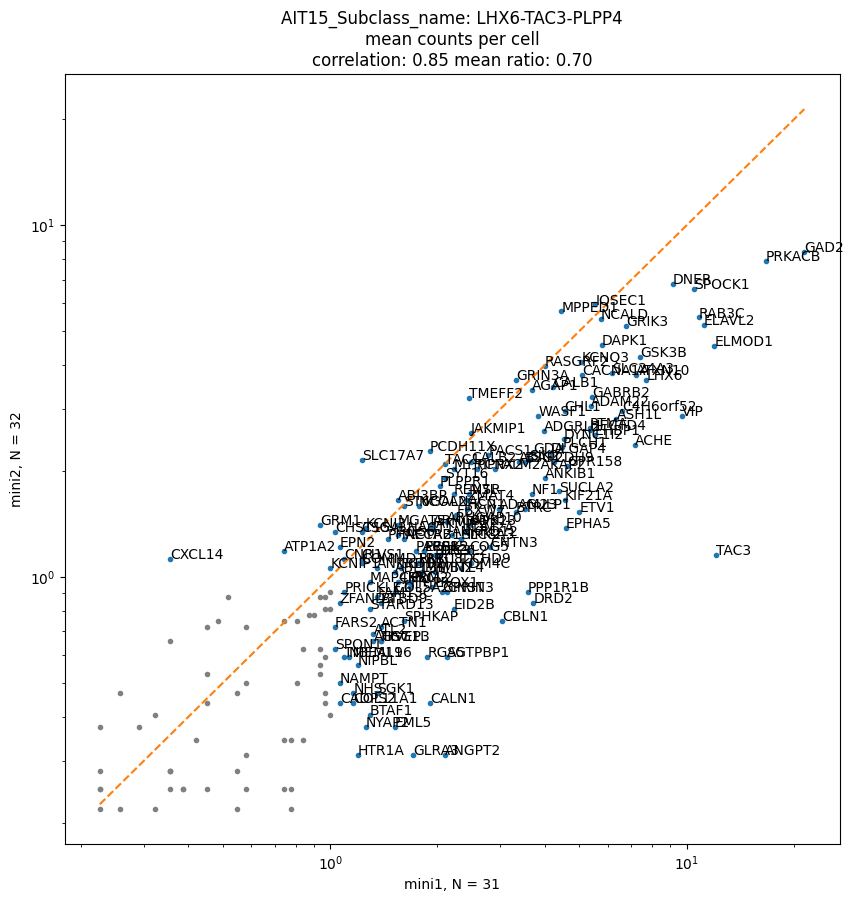

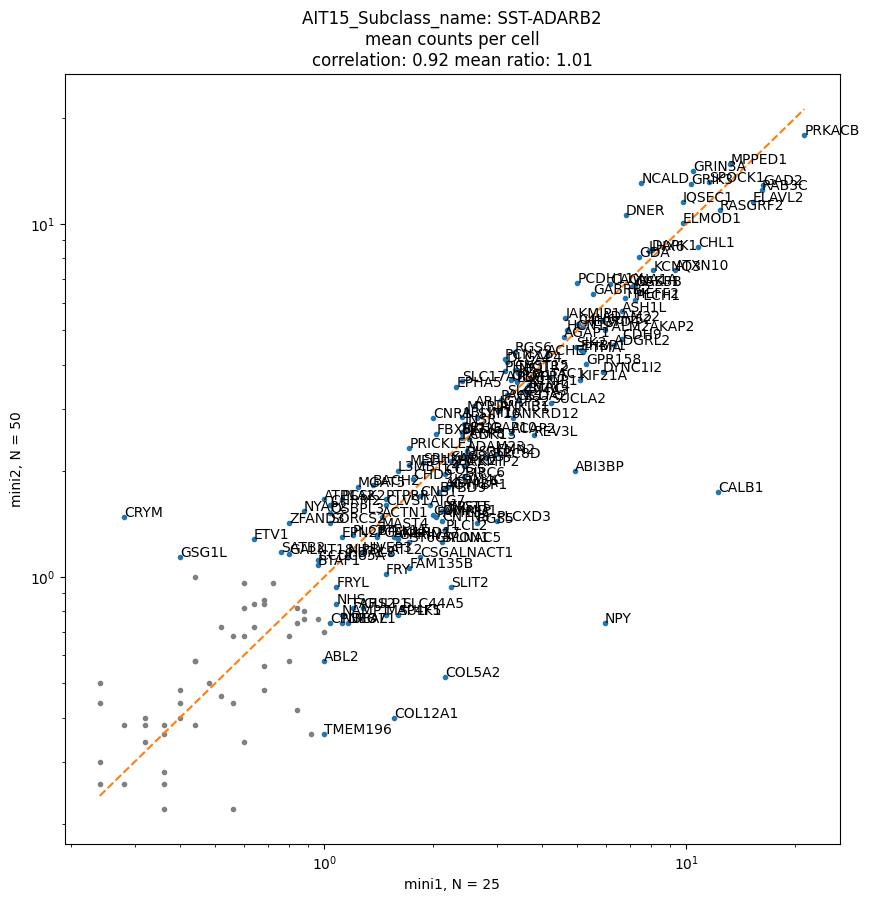

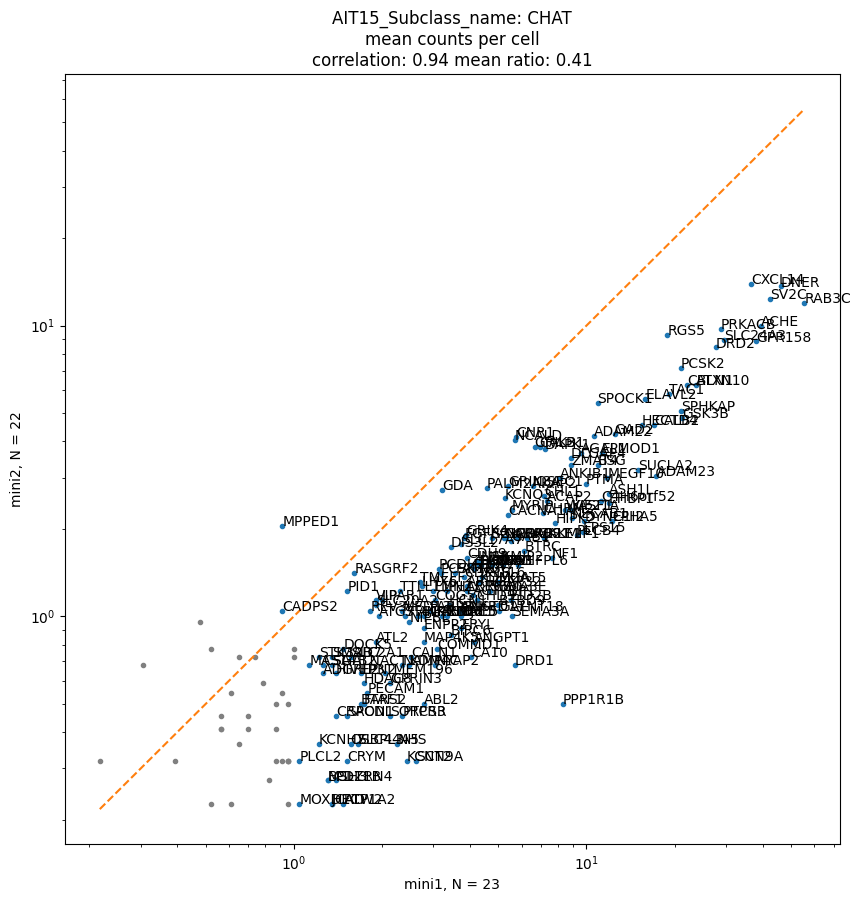

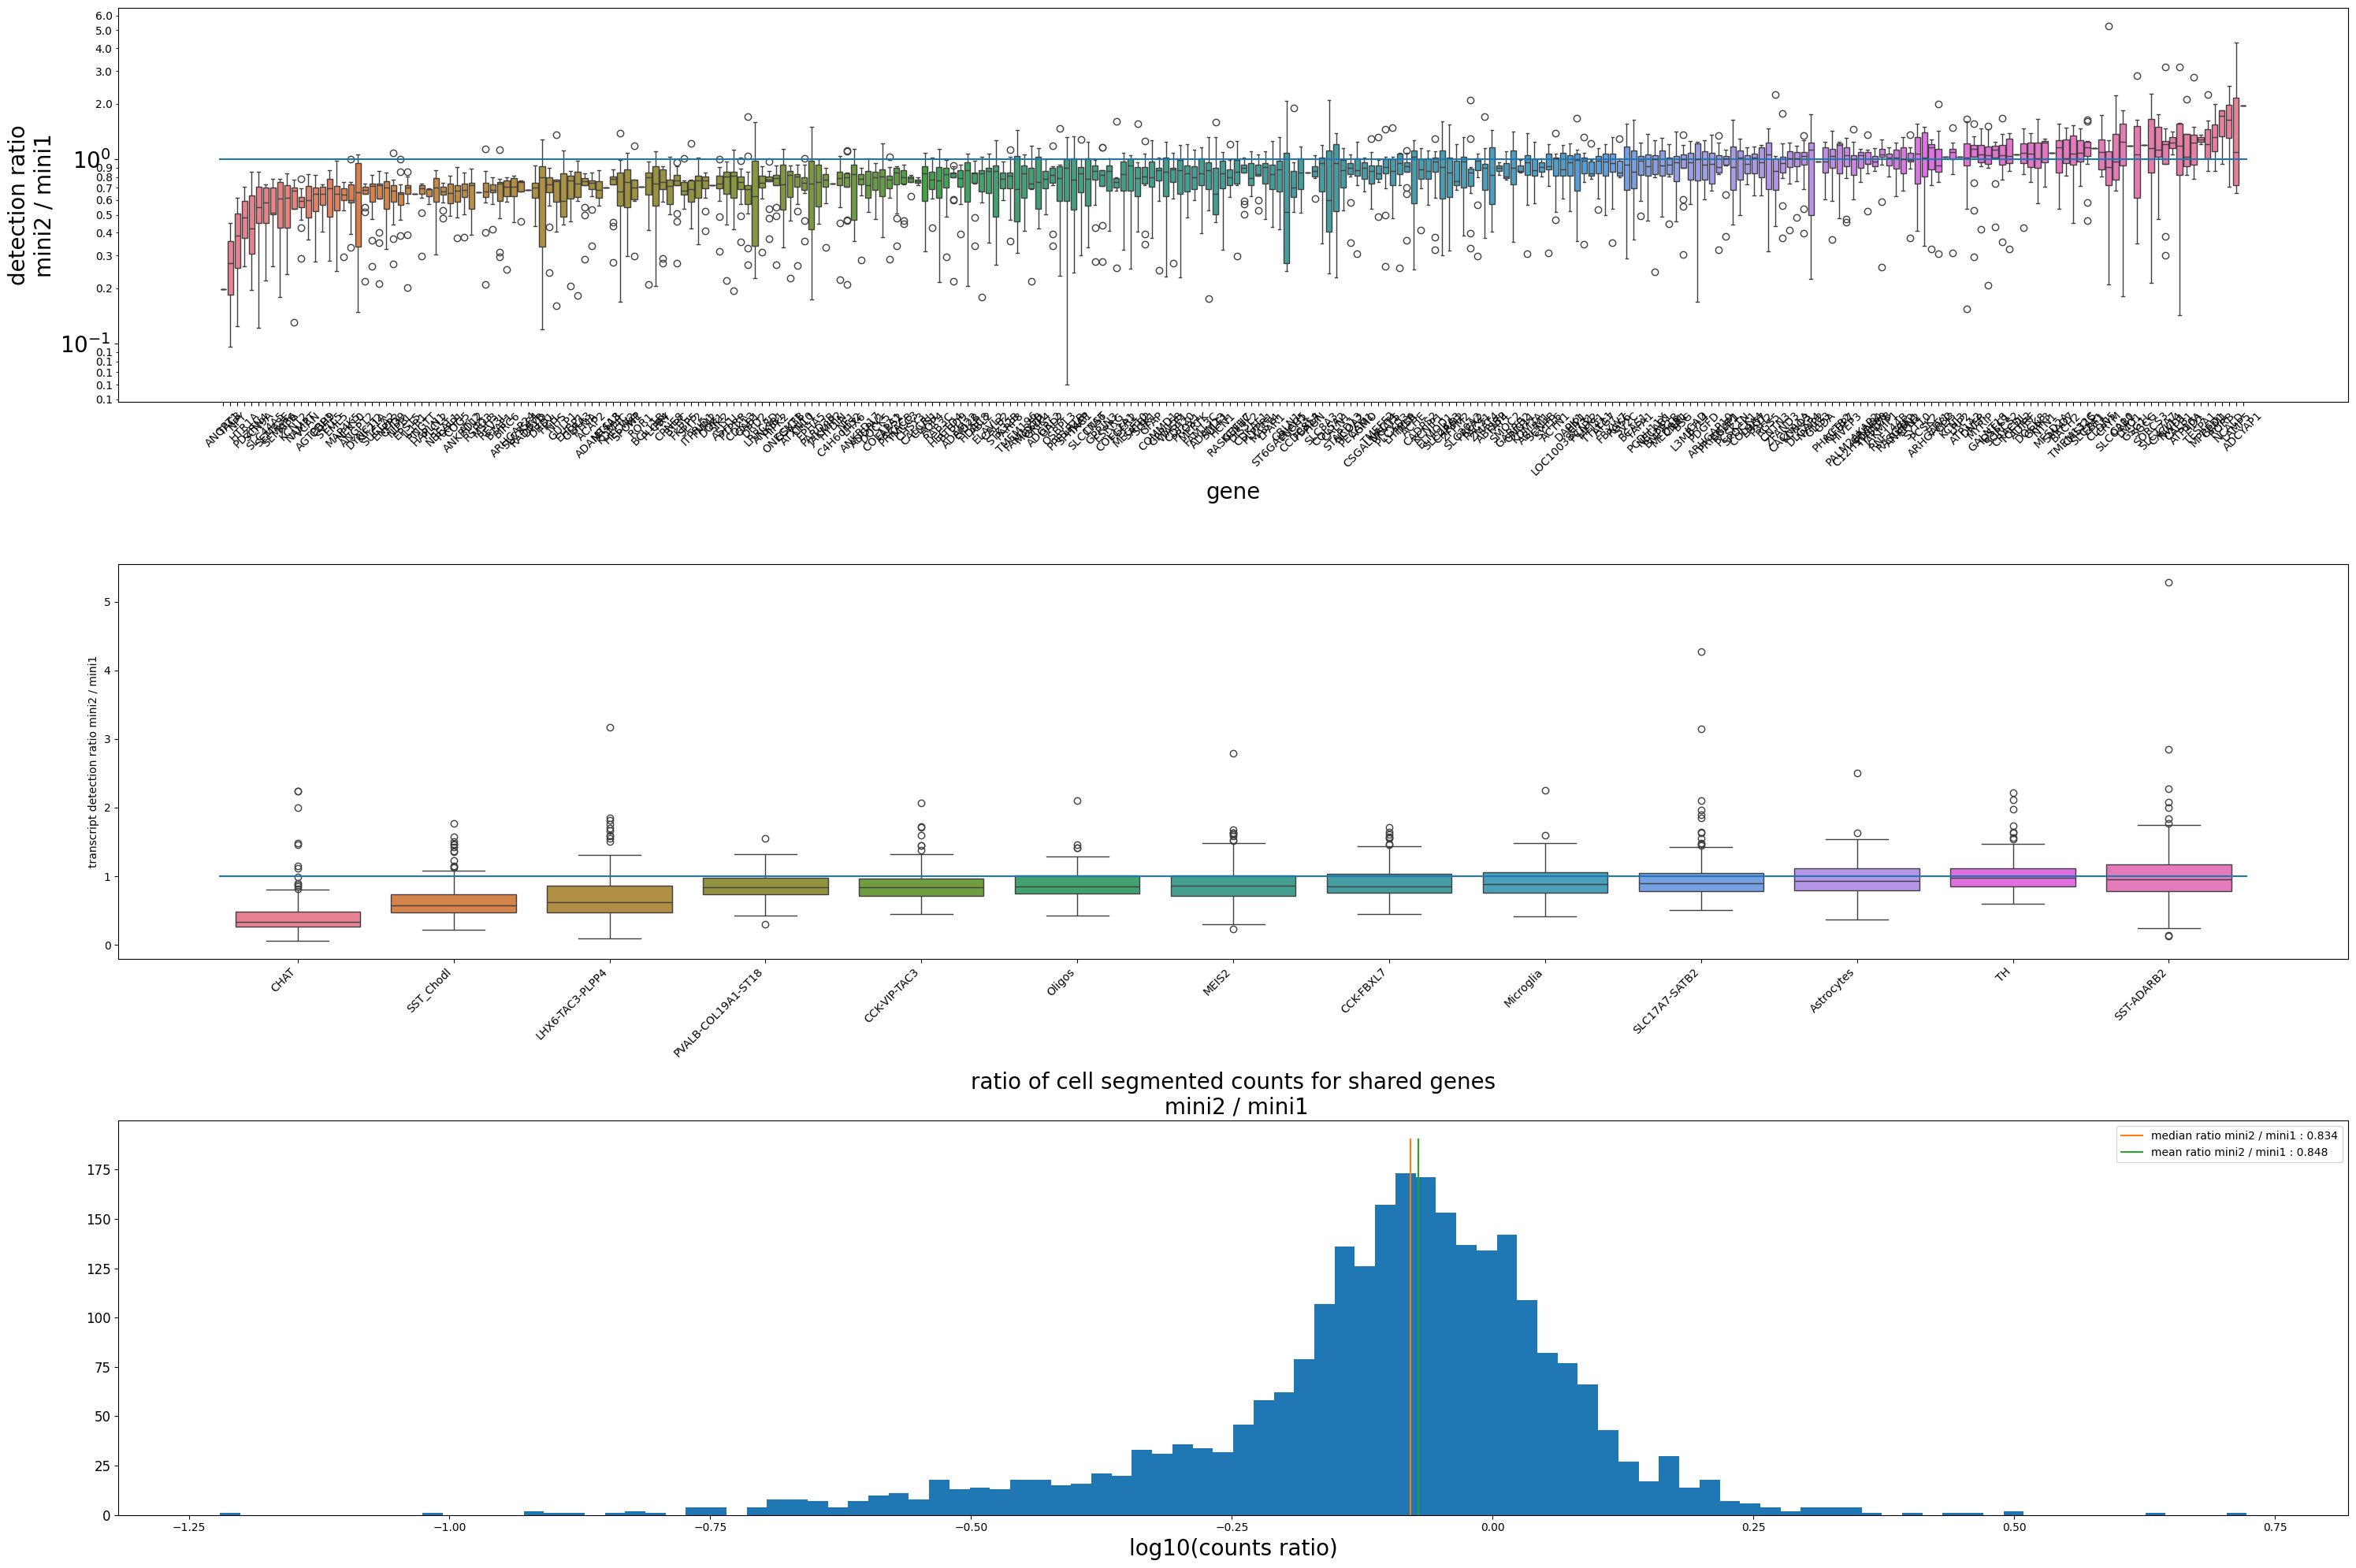

In [6]:
sc.run_and_plot(category_values = non_d1d2_cells)

# We can also use de novo clustering to define groups of cells
`spatial_compare.de_novo_cluster` uses 2 rounds of Leiden clustering with default parameters. PCs are recalculated on each 1st-round cluster for the second round. The clusters that match by highest correlation are used as the new categories. 

### NB: This method is experimental and currently modifies the `AnnData` objects being compared:
1. normalizes the `.X`
2. adds `X_pca` features to the `.obsm`
3. removes cells and genes with too few counts

In [16]:
sc.de_novo_cluster(correspondence_level="leiden_0")

converted to array  
2nd round of clustering
concatenating
converted to array  
2nd round of clustering
concatenating


/home/brianl/projects/spatial_compare/spatial_compare/utils.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)


True

/home/brianl/projects/spatial_compare/spatial_compare/spatial_compare.py:465: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10, 10])


dict_keys(['matched_leiden_0_0', 'matched_leiden_0_1', 'matched_leiden_0_2', '', 'matched_leiden_0_3', 'matched_leiden_0_4', 'matched_leiden_0_5', 'matched_leiden_0_6', 'matched_leiden_0_7', 'matched_leiden_0_8', 'matched_leiden_0_9', 'matched_leiden_0_10', 'matched_leiden_0_11', 'matched_leiden_0_12', 'matched_leiden_0_13', 'matched_leiden_0_15', 'matched_leiden_0_16', 'matched_leiden_0_18', 'matched_leiden_0_20', 'matched_leiden_0_21', 'matched_leiden_0_22'])


True

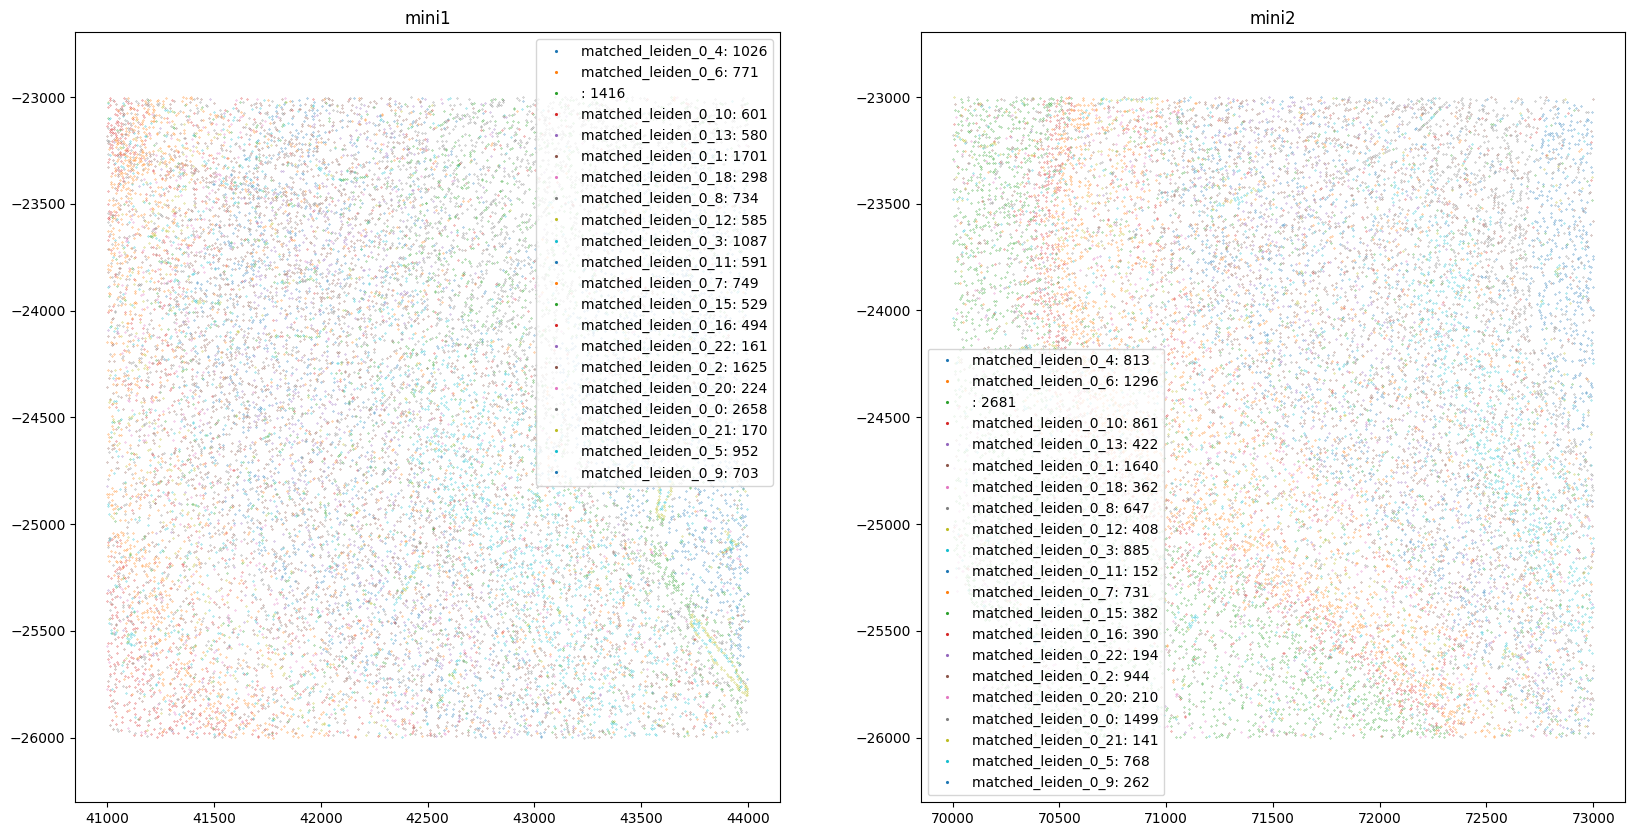

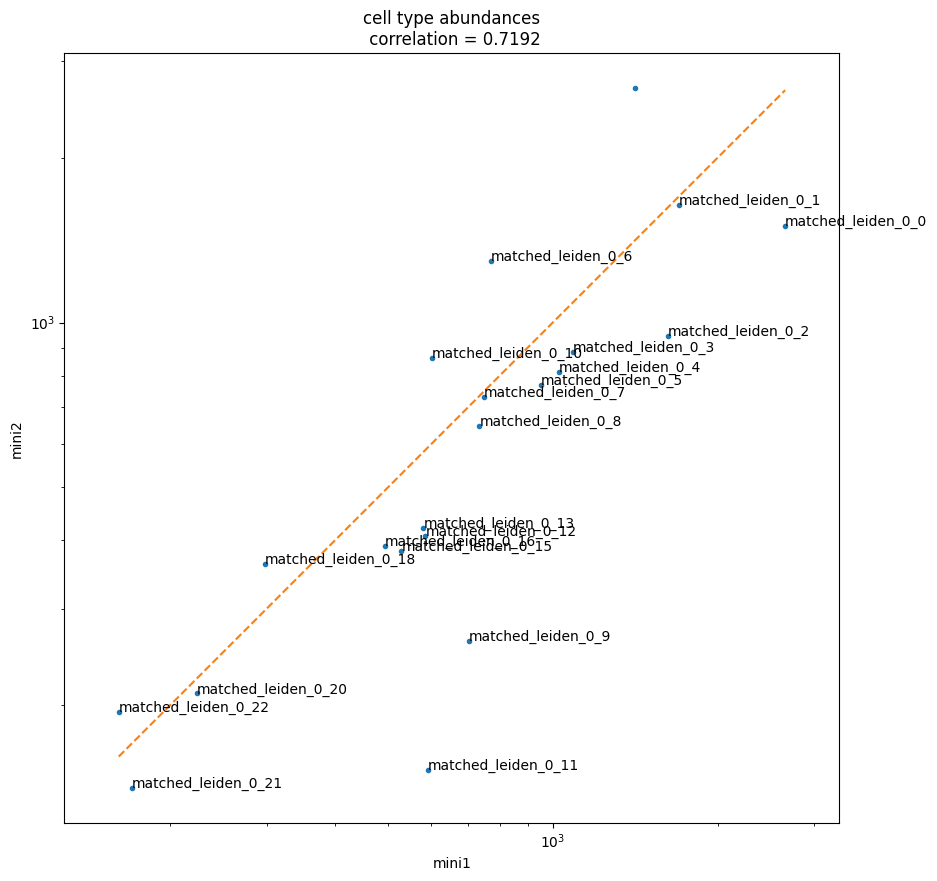

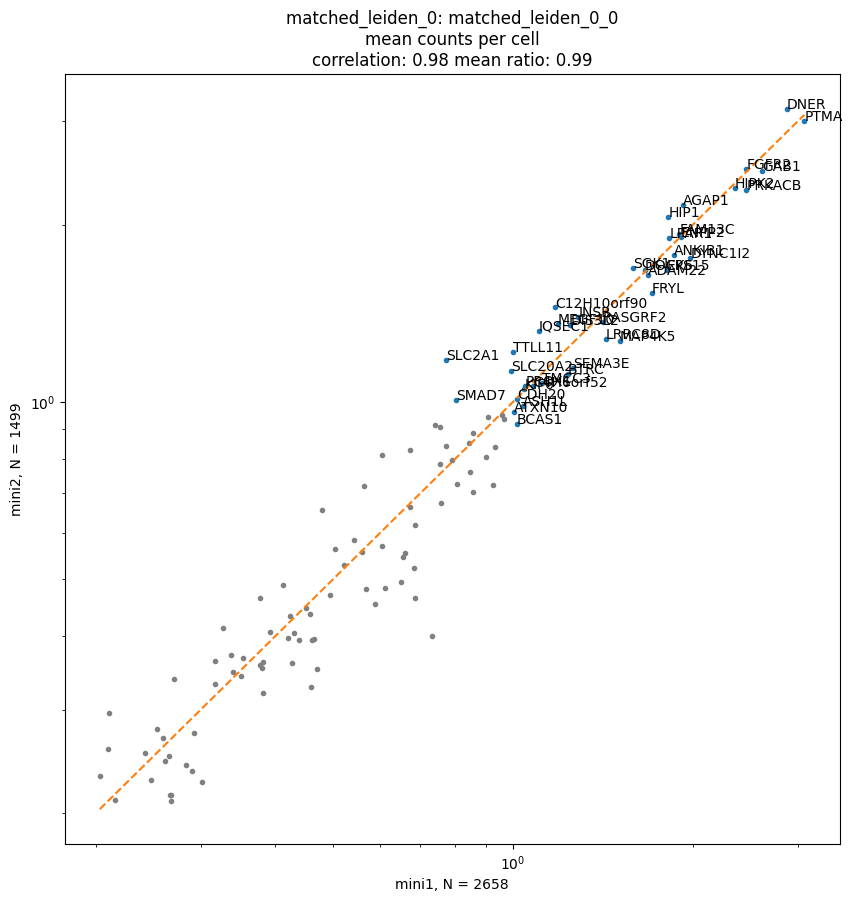

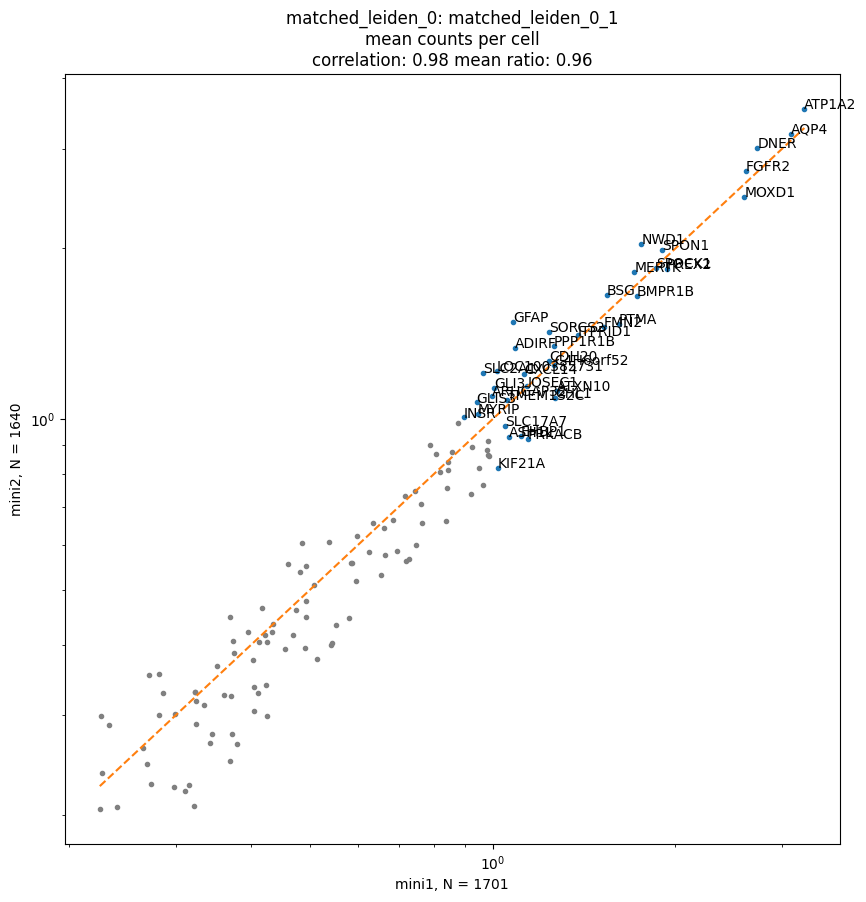

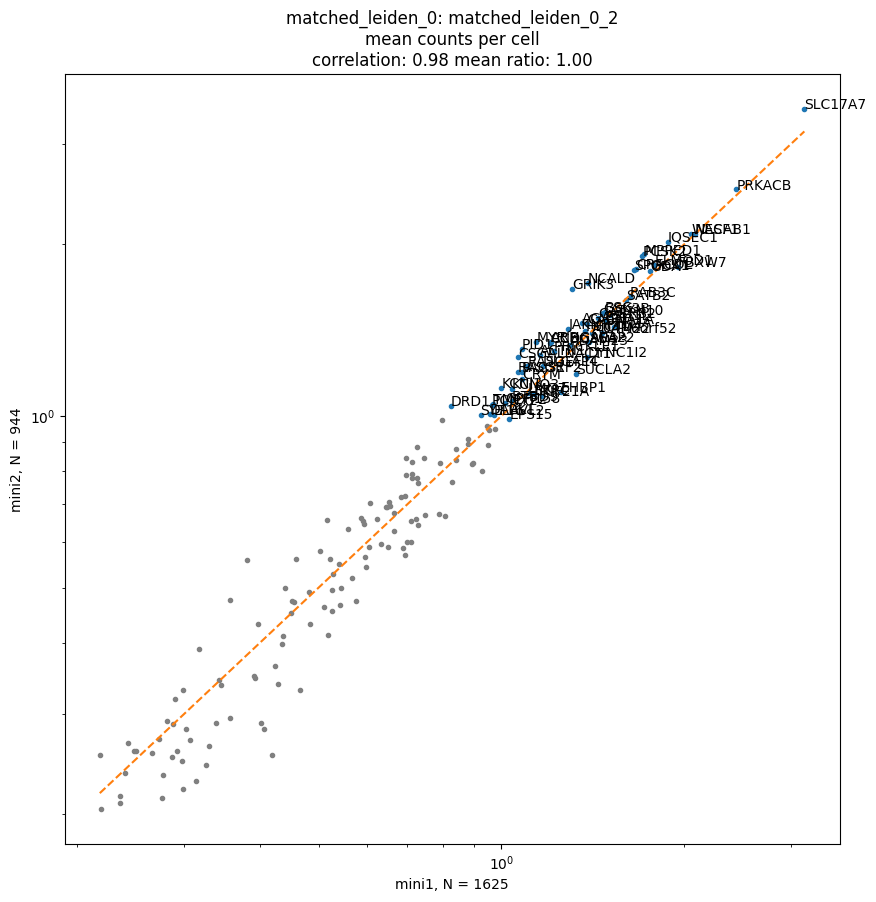

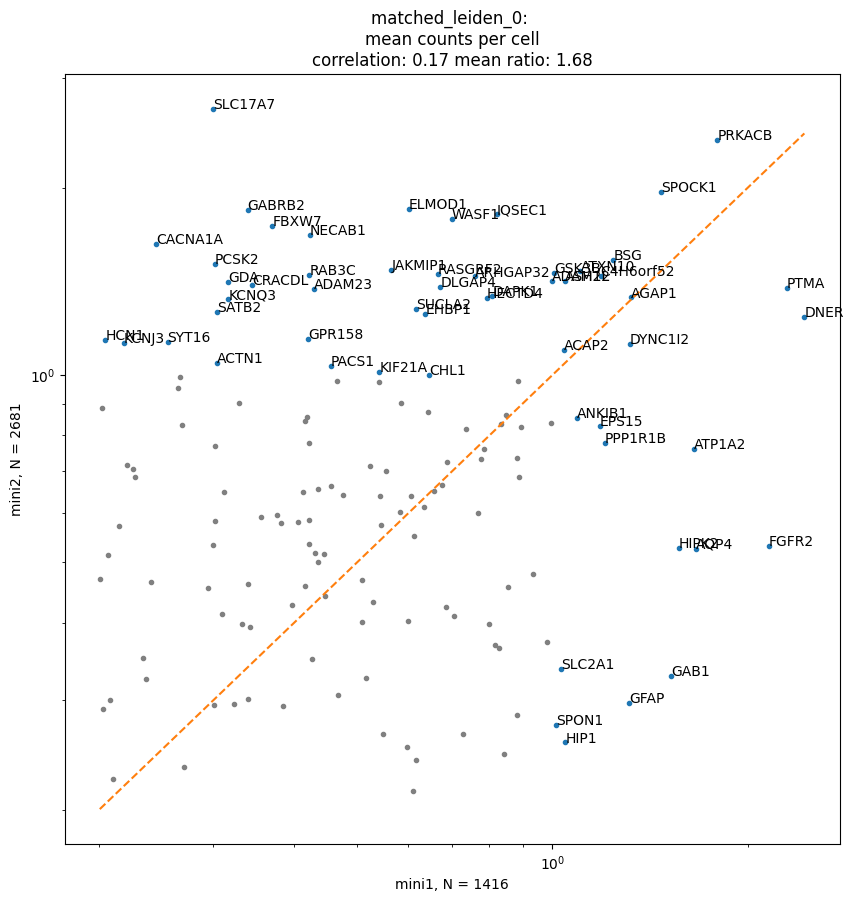

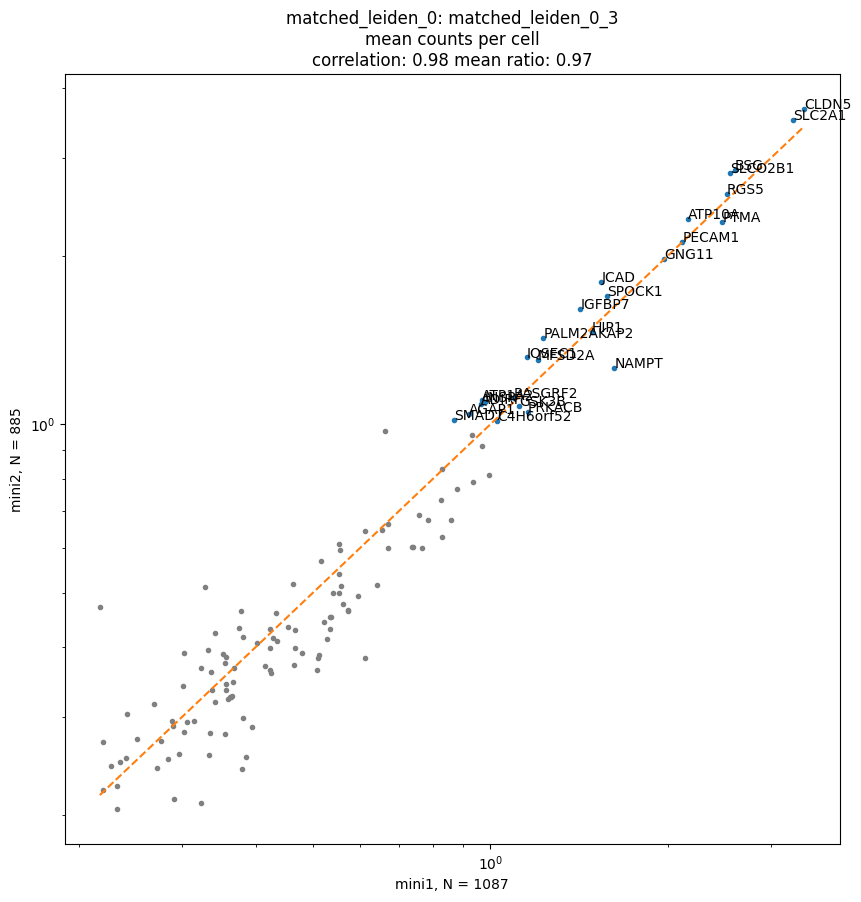

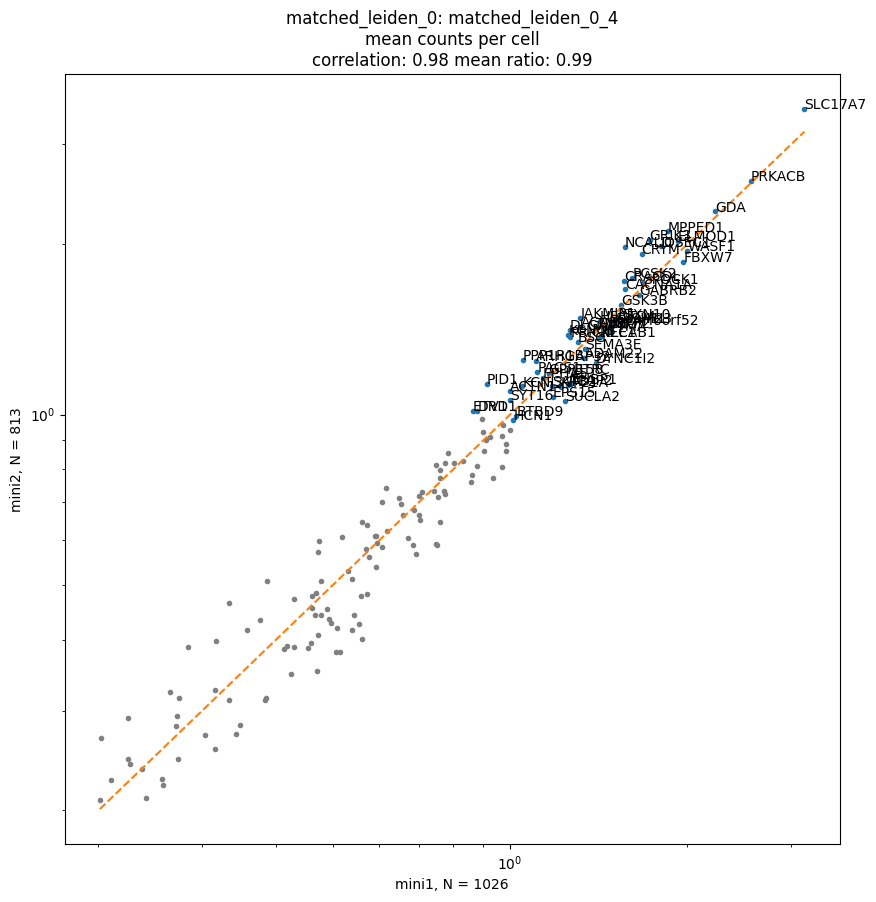

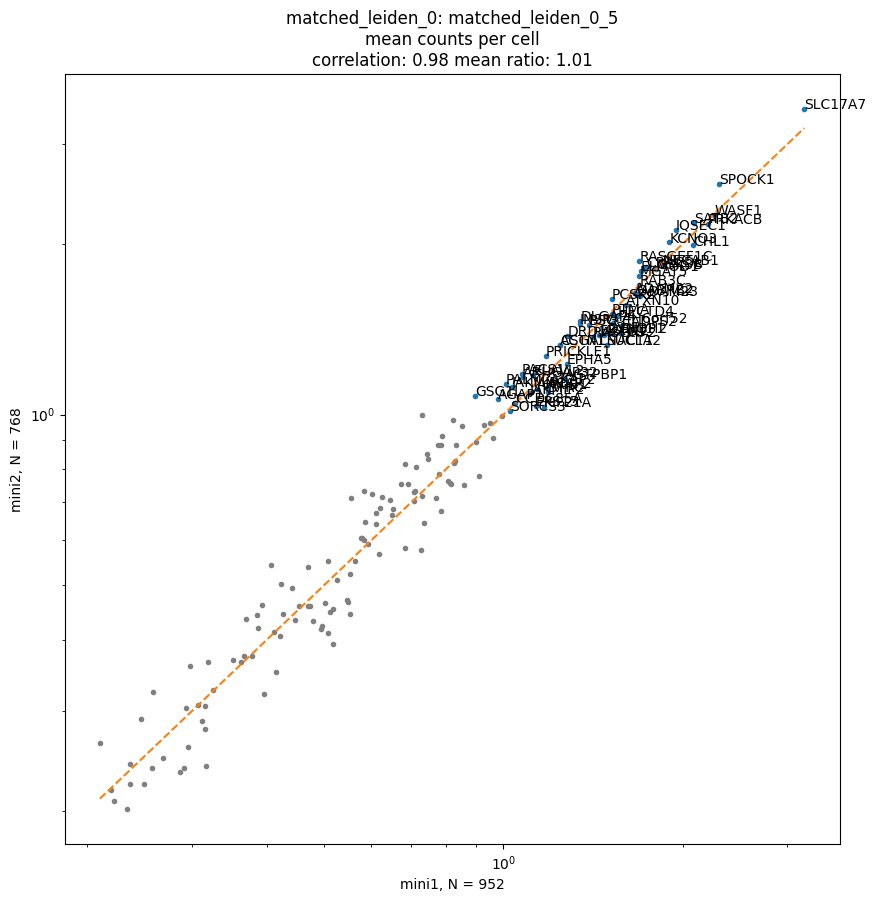

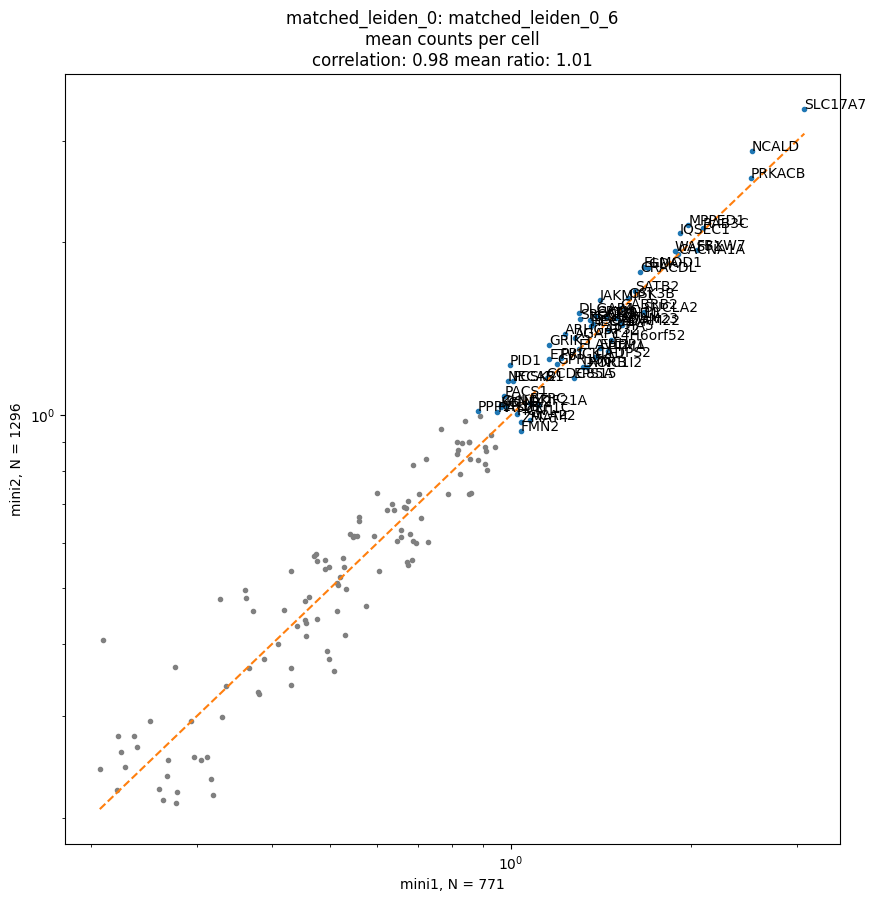

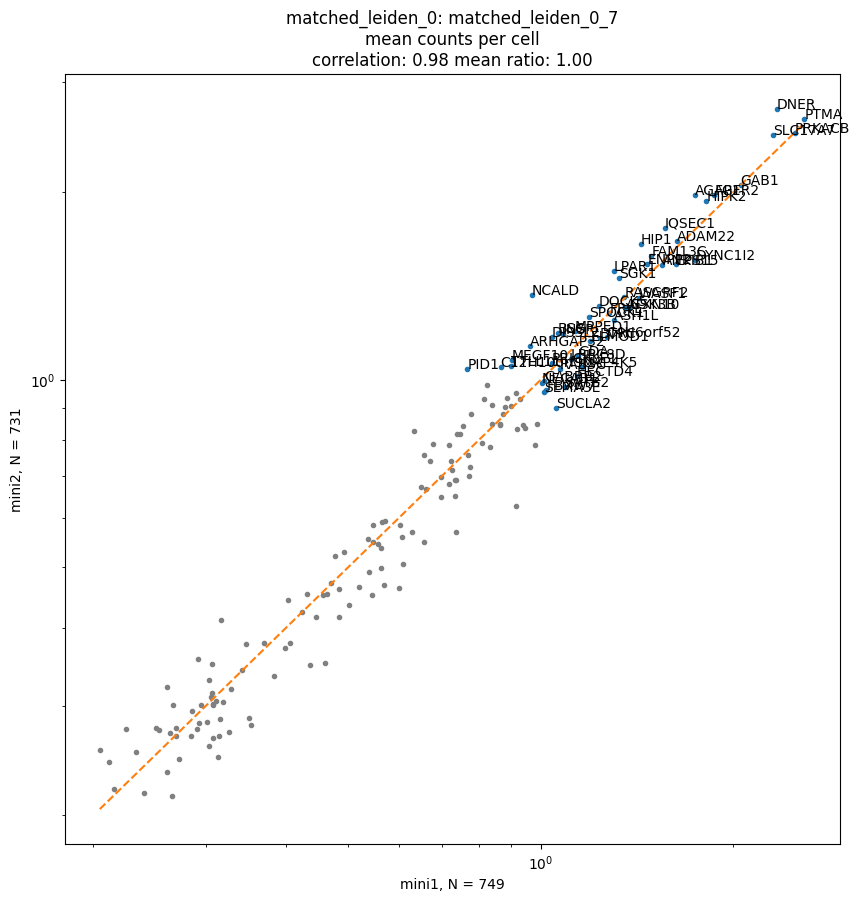

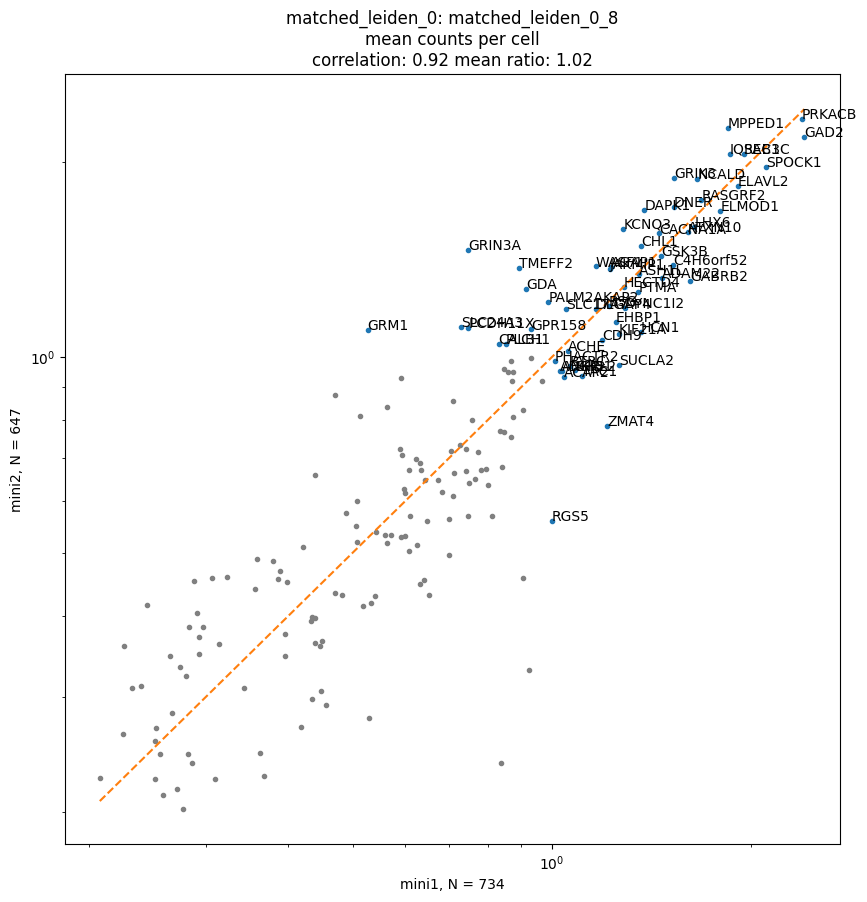

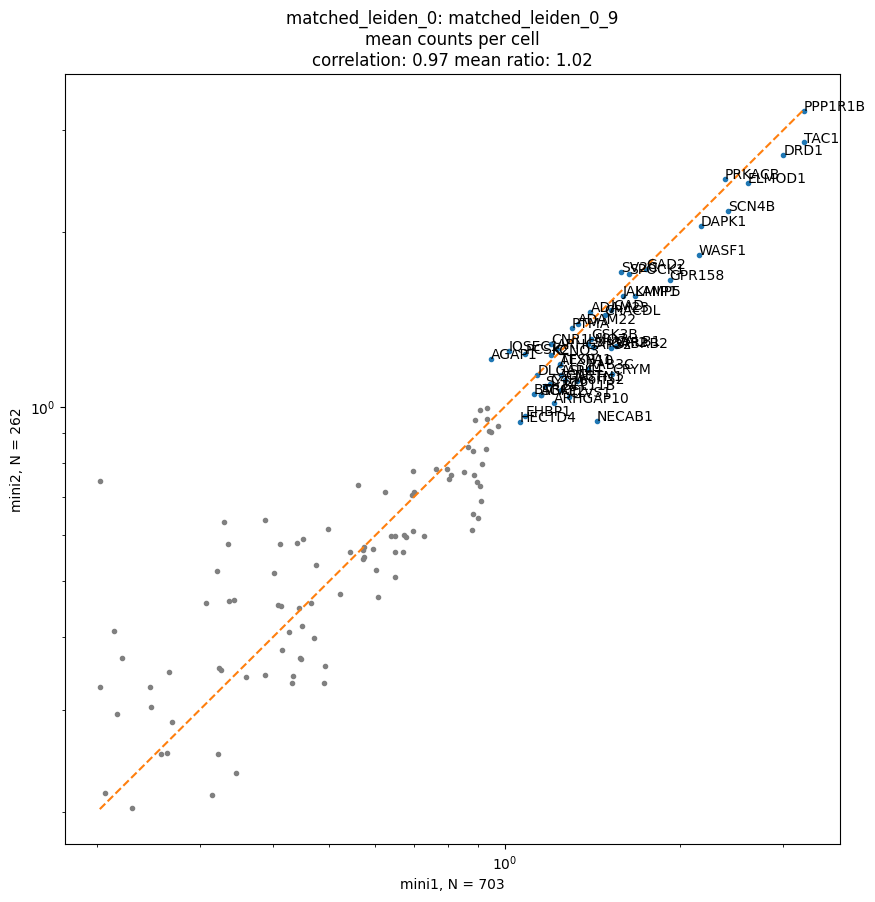

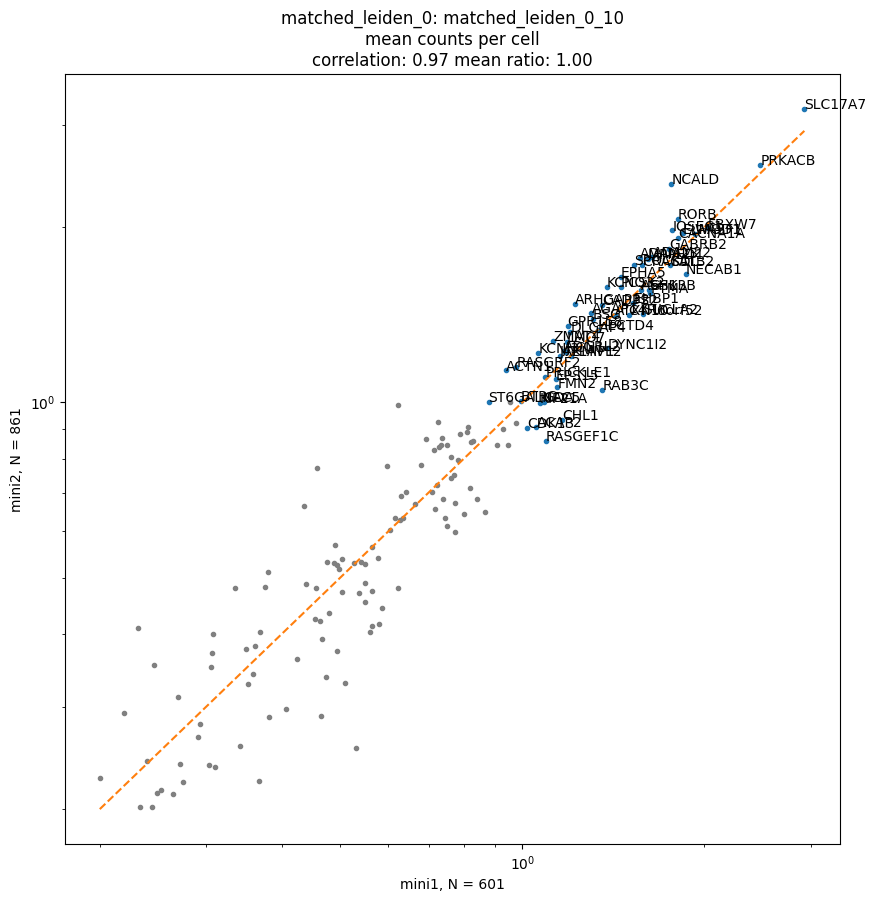

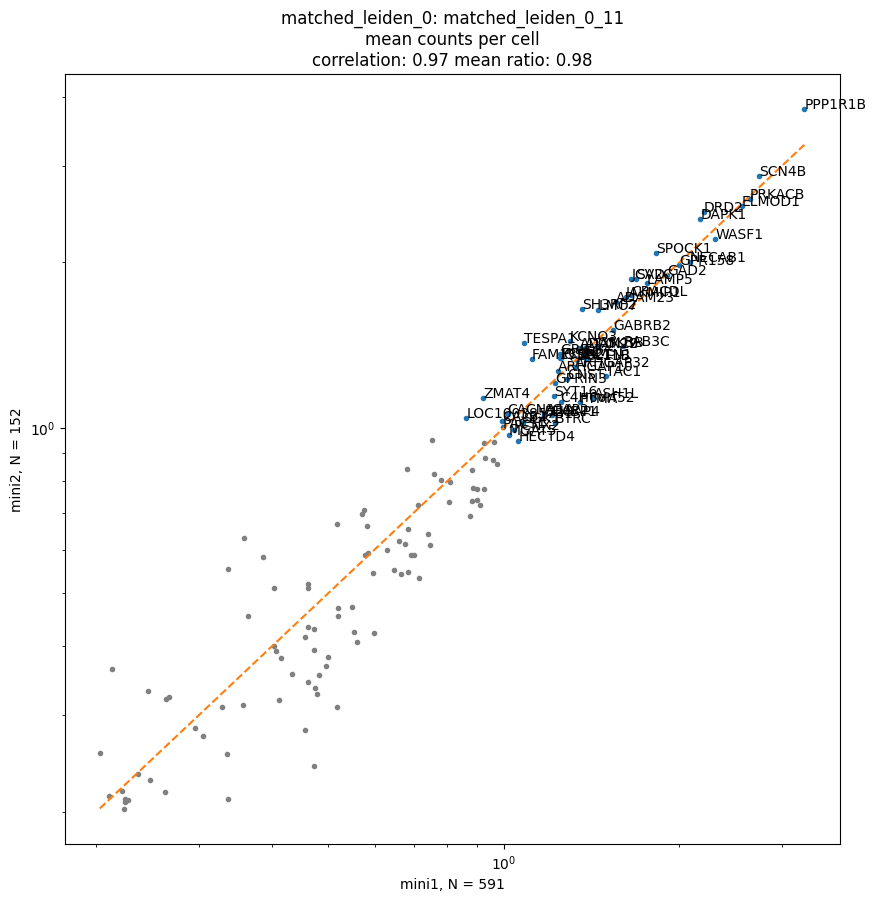

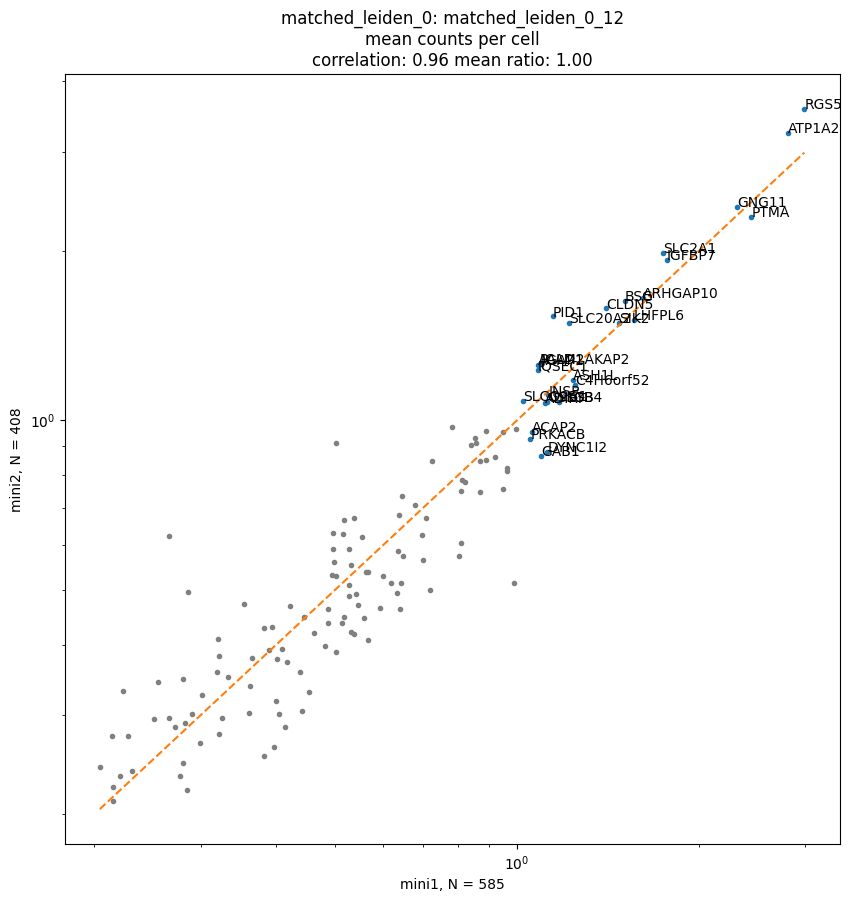

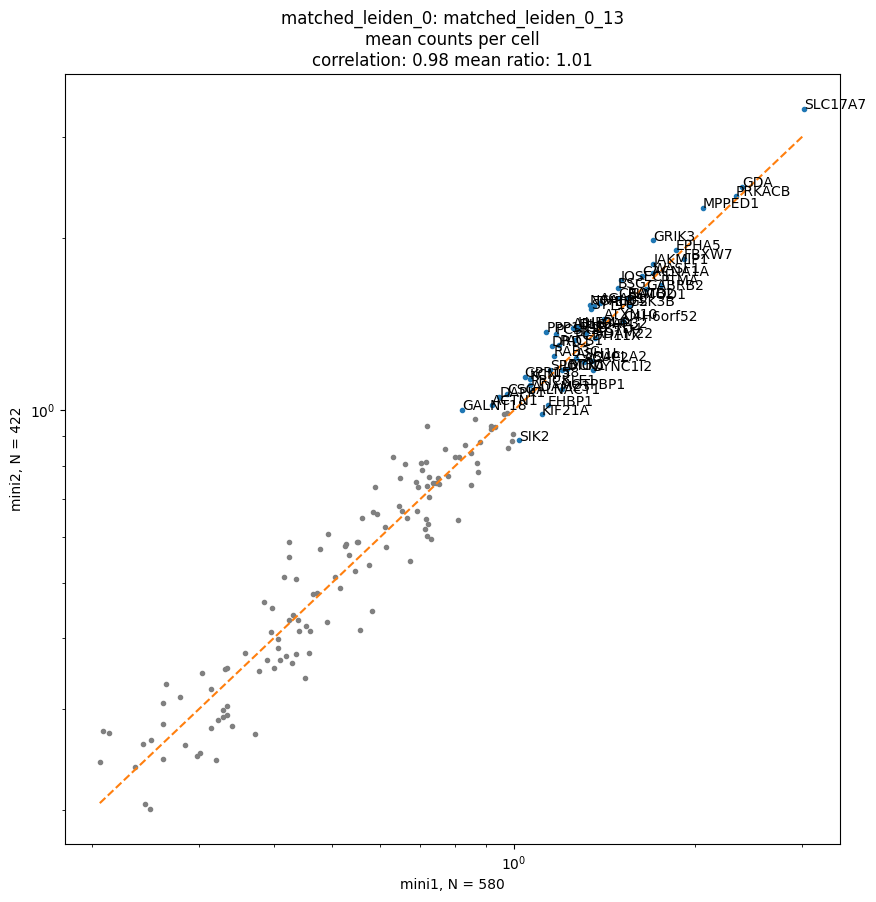

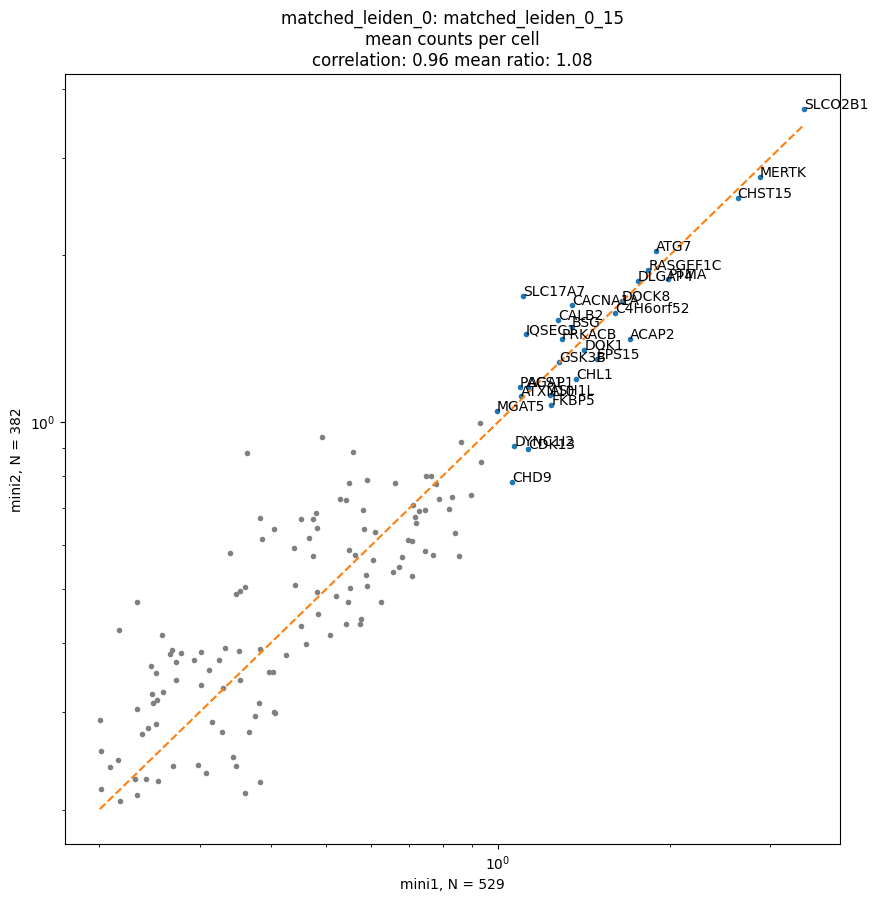

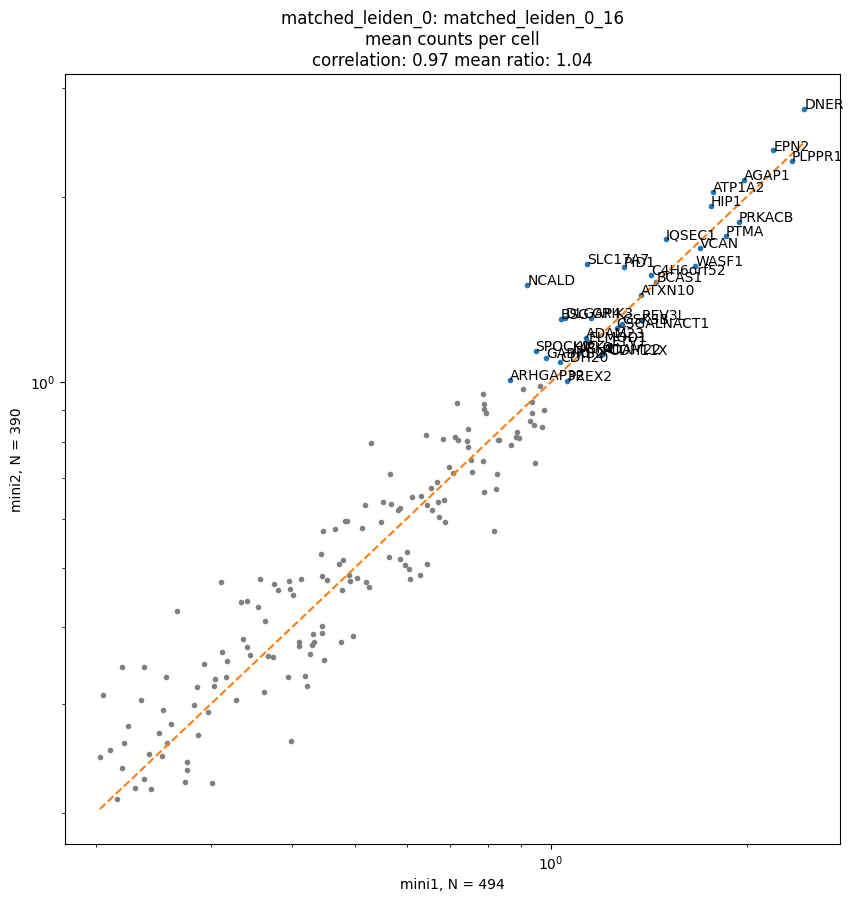

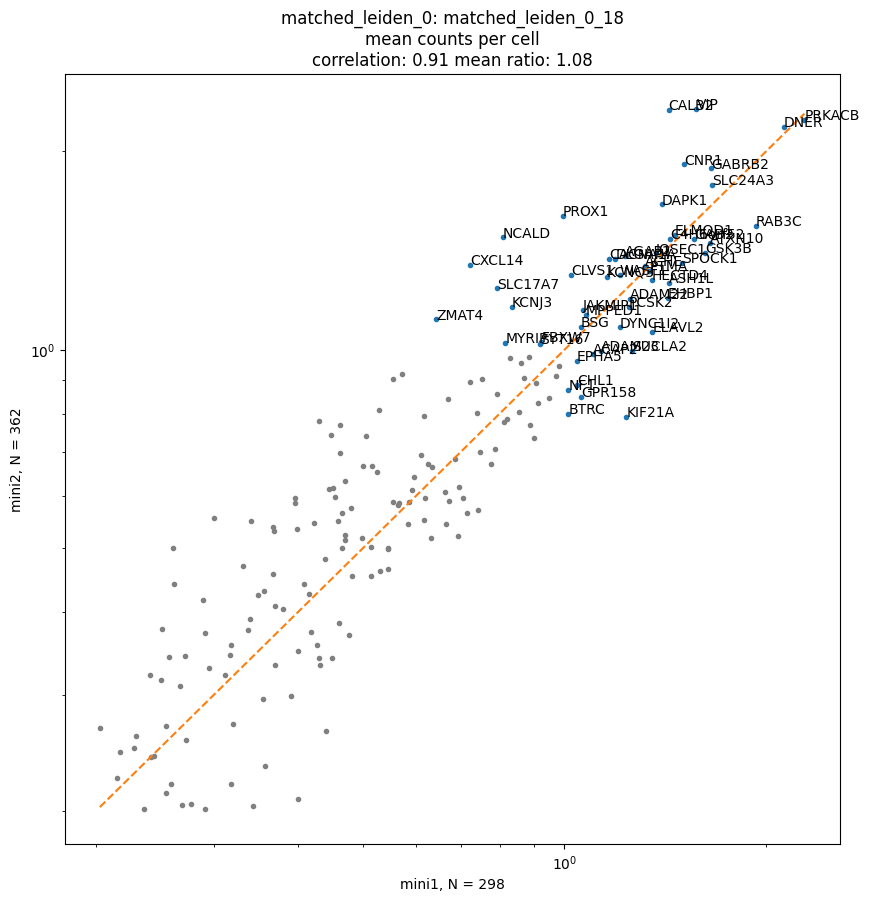

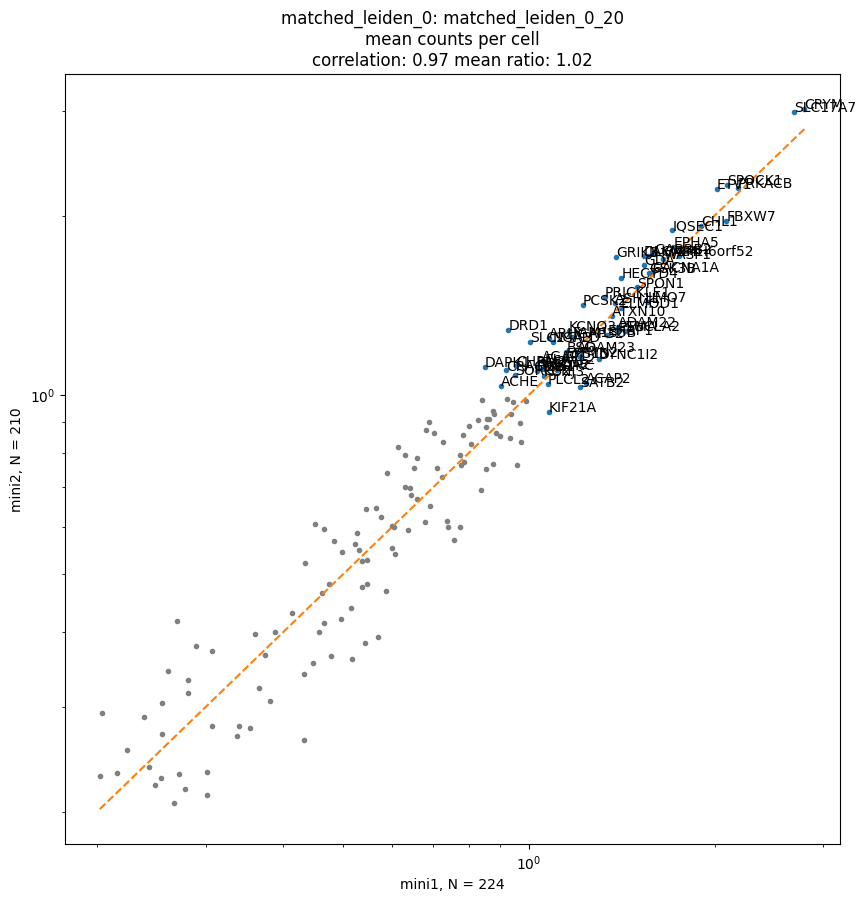

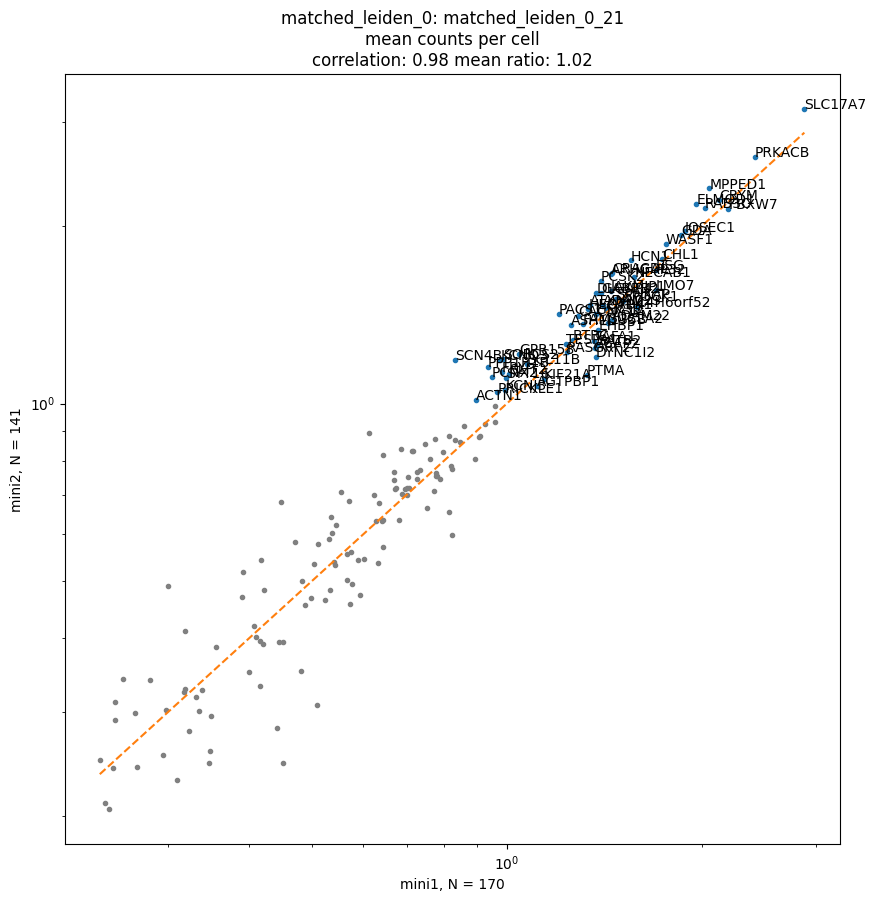

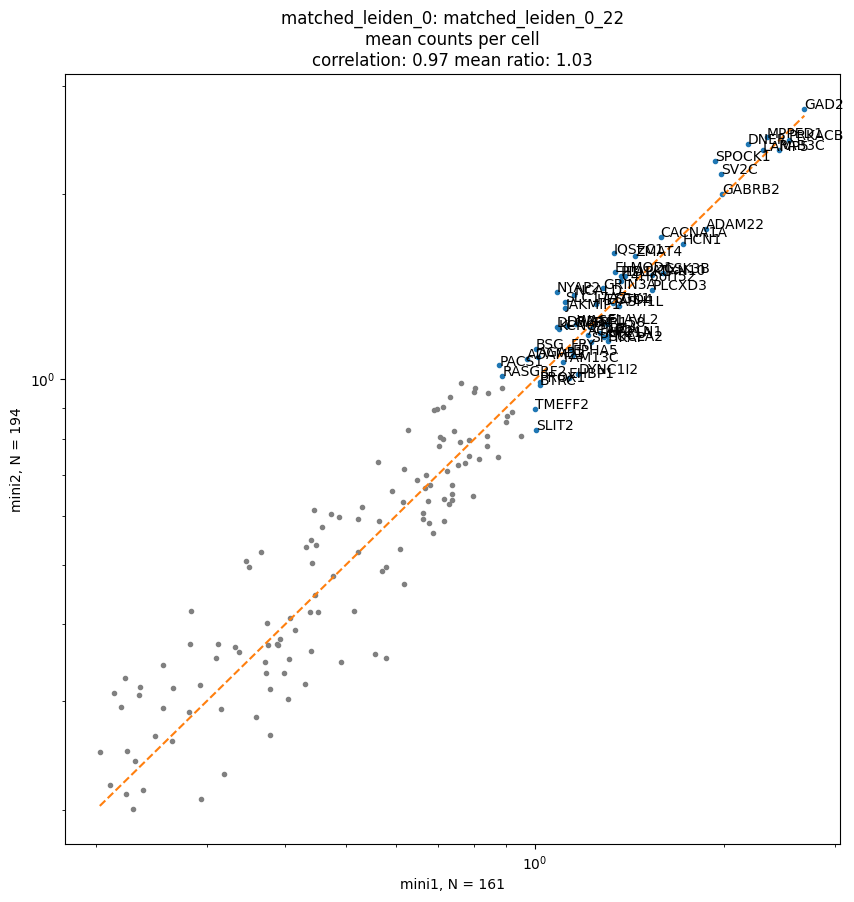

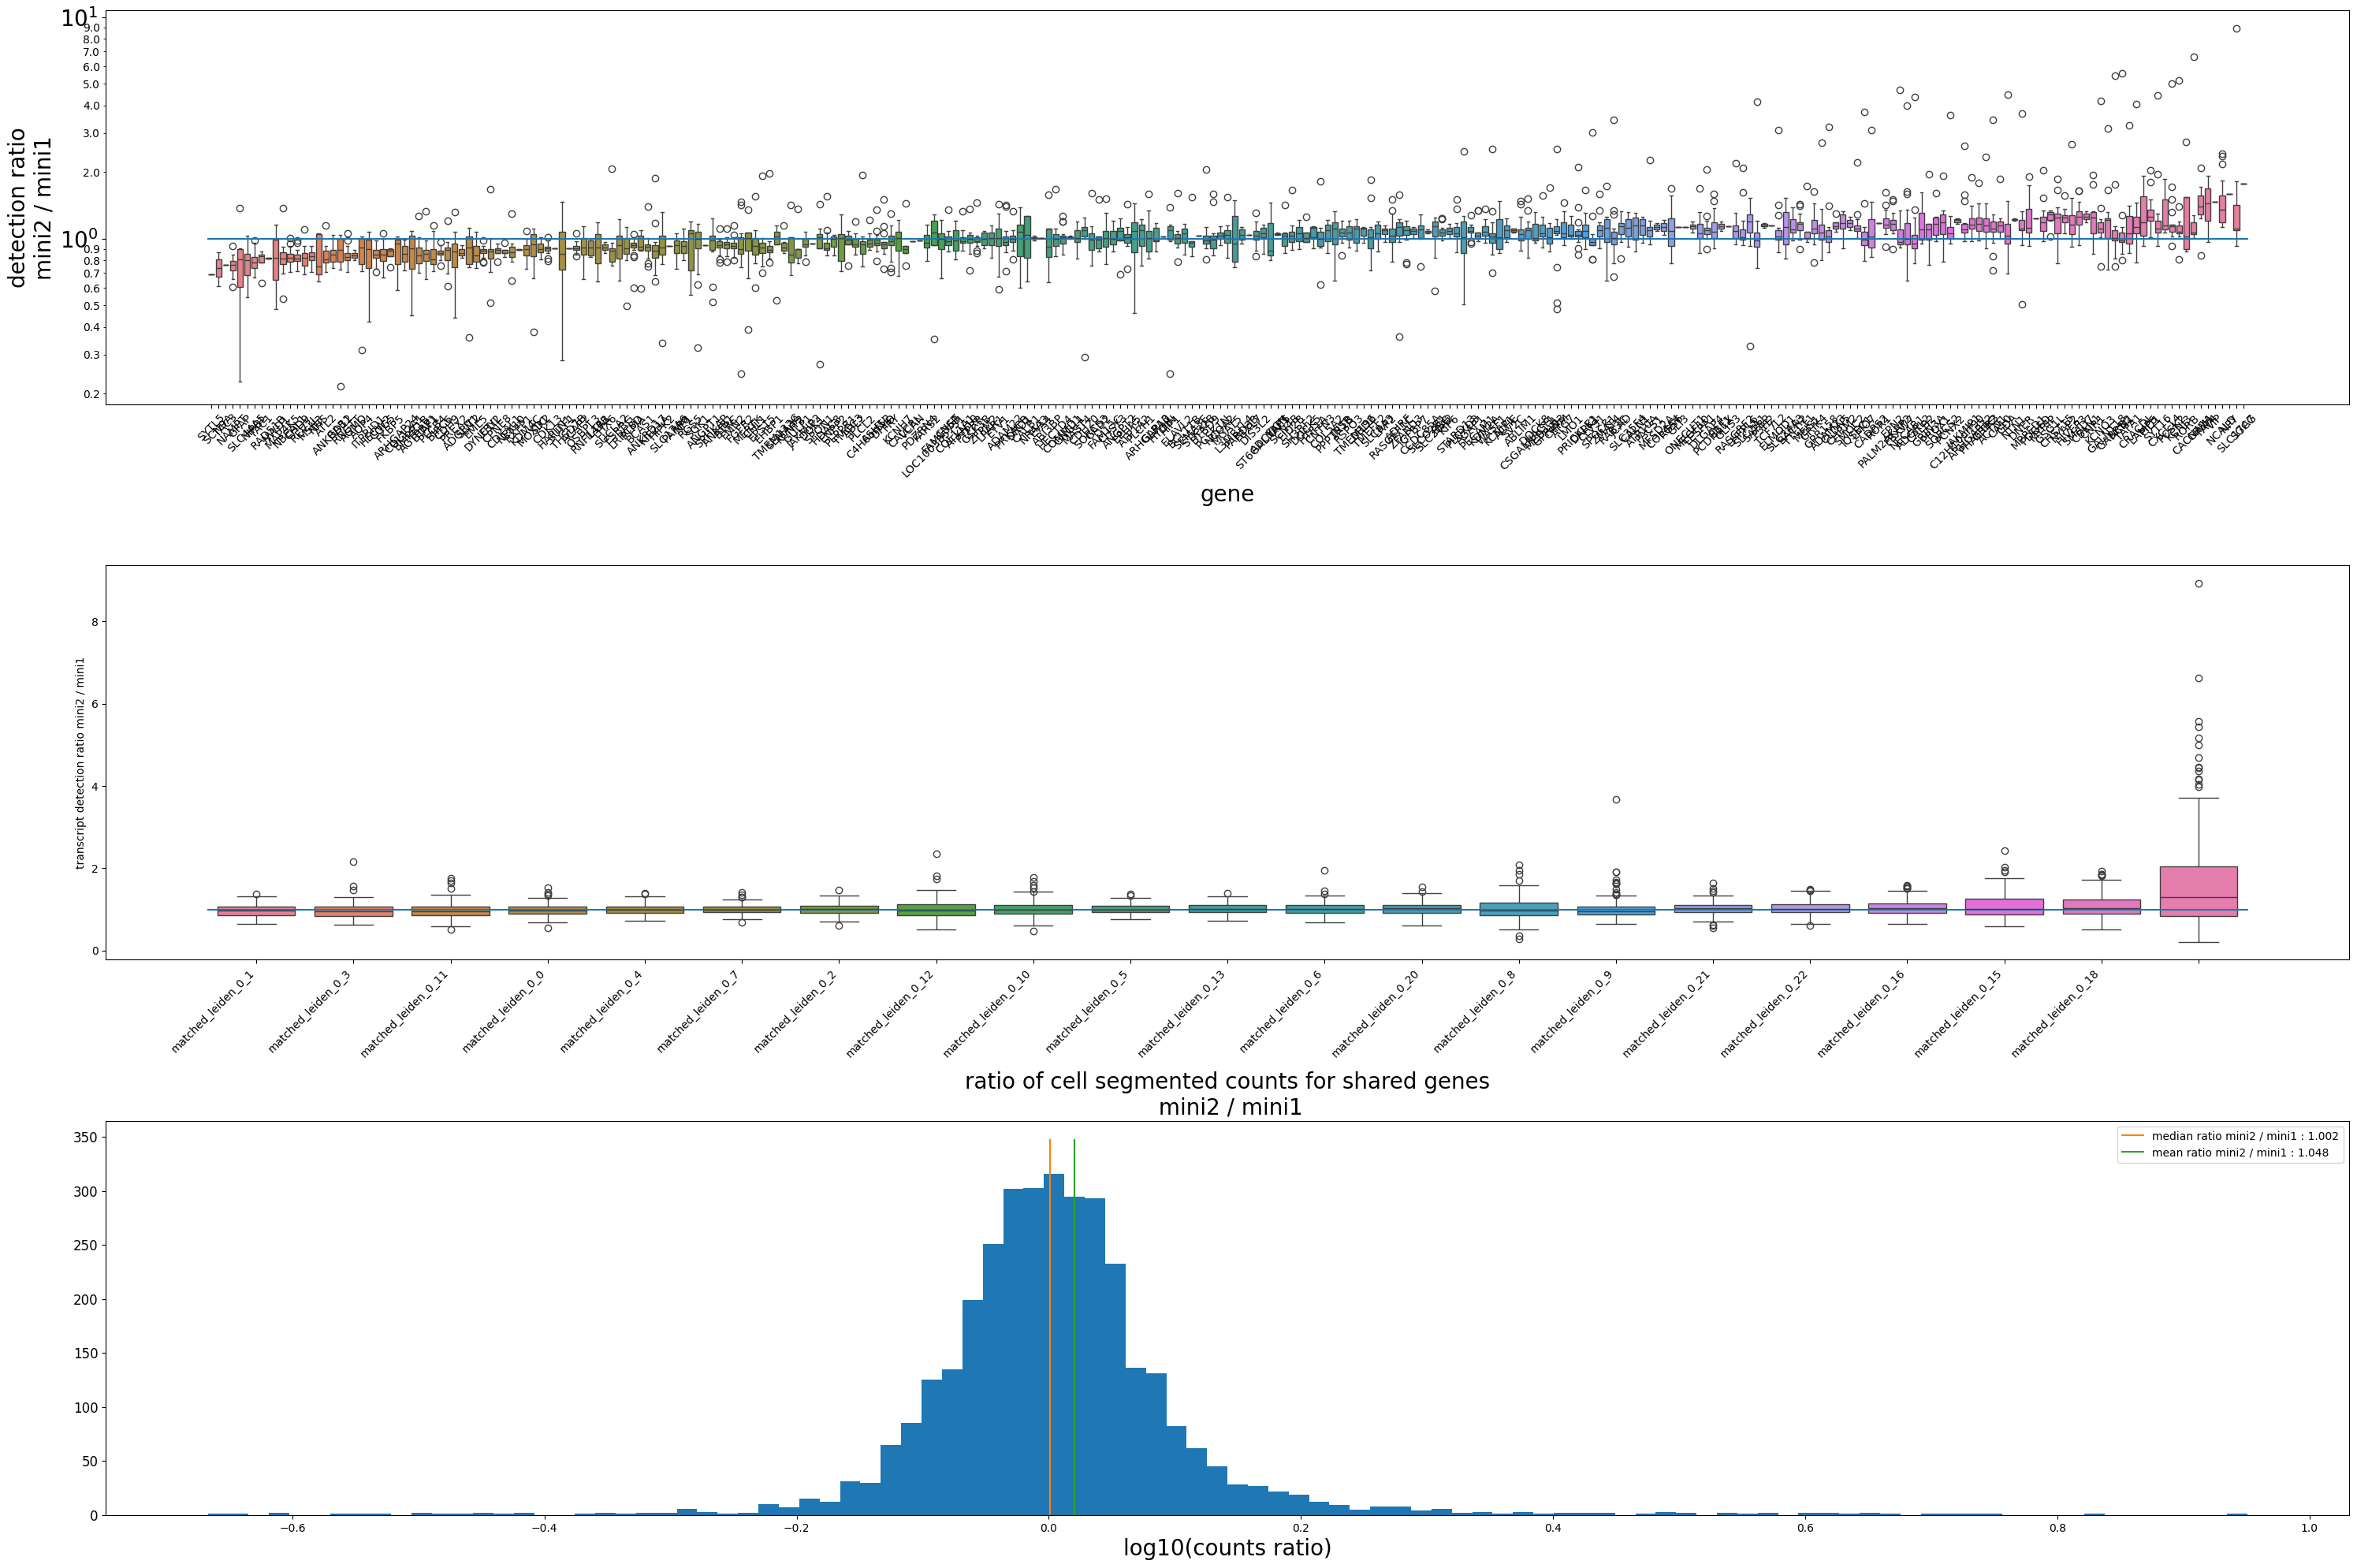

In [17]:
sc.run_and_plot()

# Spatial Detection Scores
We can also look at how transcript detection varies across the data, guided by the statistics of expression for each group in a reference dataset. Here I create a reference from the 4 AnnData objects we loaded above, and 1 of the datasets is queried against that combined reference. Once all groups have been compared, the results (total detection z-score, difference in total counts and log10(detection ratio) are binned across the dataset to produce a spatial map of detection.  



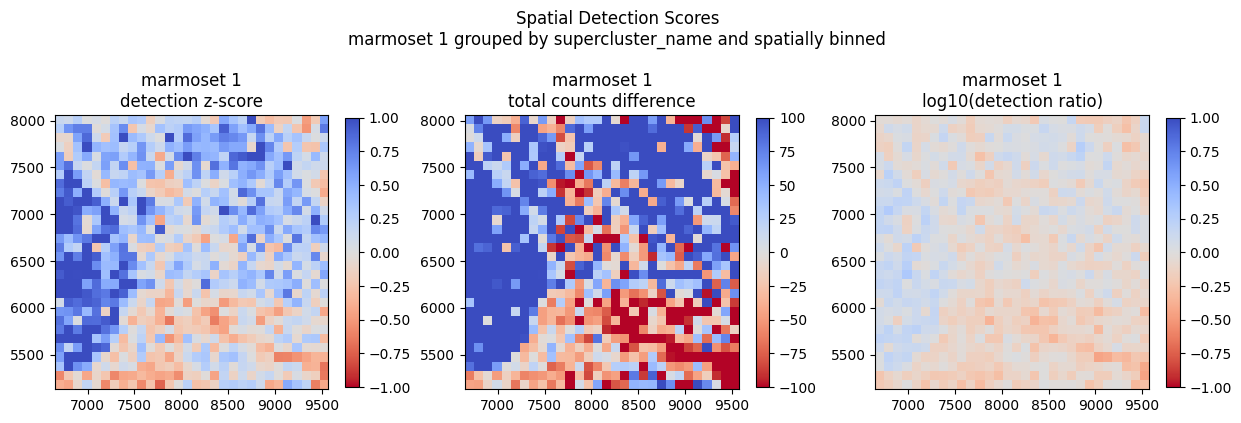

In [11]:
combined_reference = pd.concat([ad1.obs,ad2.obs, ad3.obs, ad4.obs], axis=0)
s = spatial_detection_scores(combined_reference,ad1.obs, query_name="marmoset 1", n_bins=30,non_spatial=False)



The function `spatial_detection_scores` can also be called with `non_spatial=True` option that ignores the per-group statistics and just returns spatial maps compared to all cells in the reference. As seen below, this non-spatial version of relative detection is confused by the per-group variation in total transcripts, incorrectly highlighting a white matter region with fewer counts as a large negative z-score for detection.

 s = spatial_detection_scores(combined_reference,ad1.obs, query_name="marmoset 1", n_bins=30,non_spatial=True)

# same two plots for a different query dataset

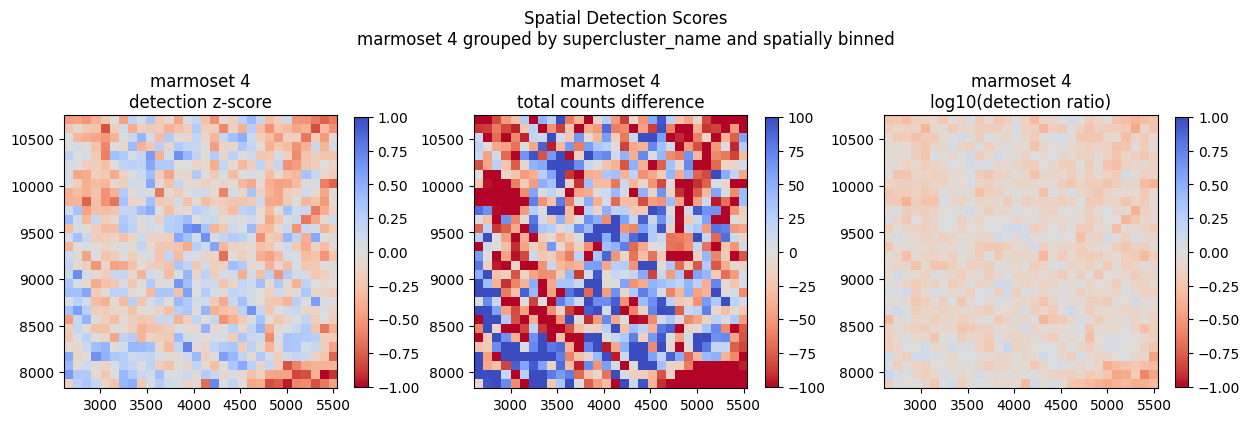

In [12]:
s = spatial_detection_scores(combined_reference,ad4.obs, query_name="marmoset 4", n_bins=30,non_spatial=False)


The non-spatial version below incorrectly emphasizes the lower left corner as having high detection (z-score approaching 1), when in fact, the cell groups there have normal detection as seen above.

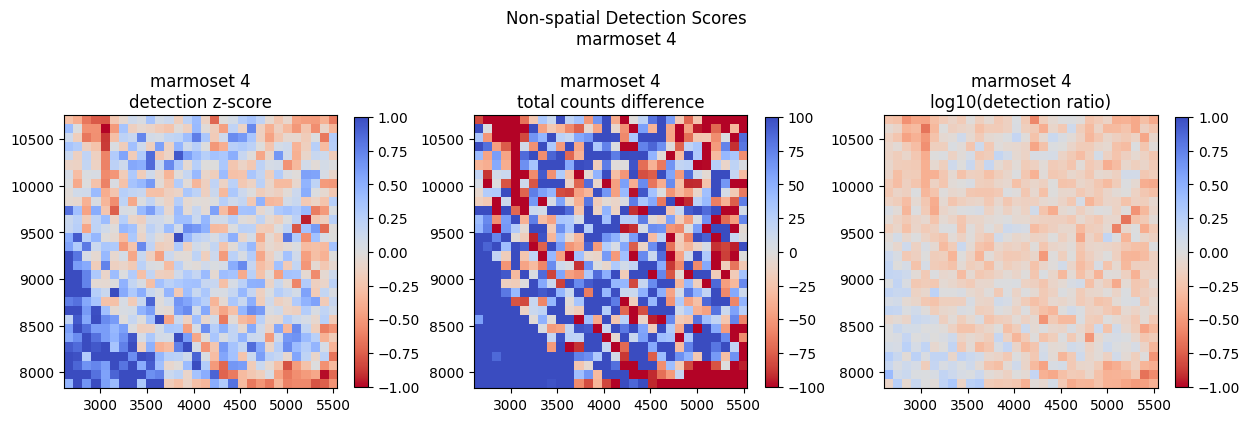

In [13]:
s = spatial_detection_scores(combined_reference,ad4.obs, query_name="marmoset 4", n_bins=30,non_spatial=True)
